<a href="https://colab.research.google.com/github/VictorGlezDiez/VIU_TFM_TimeSeries/blob/master_VIU/Matric_DIARIO_estable_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Máster en Big Data y Data Science - Visualización de datos**

**Víctor González Díez**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.google.es"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://www.google.es"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Ver en GitHub</a>
  </td>
      <td>
    <a href="https://www.google.es"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Descargar notebook</a>
  </td>
</table>

##**<font color=grey>Instalar paquetes y librerías</font>**

####**Paquete `tbats`**

In [ ]:
!pip install tbats

     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.4 MB 42.3 MB/s 
     |████████████████████████████████| 9.8 MB 49.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


####**Paquete `Prophet`**


In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 49 kB 764 kB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640166 sha256=960efeac8761e1e98a52b82ce07749ca7b93fea4437005861009c1967a8c0465
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


####**Instalar librerías**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

In [ ]:
# Para cargar los datos
import io
from google.colab import files

In [ ]:
# Análisis
from pandas.plotting import autocorrelation_plot # funciones autocorrelación
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición estacional
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller
from scipy.stats import boxcox # transformación box-cox
from scipy.special import inv_boxcox # invertir transformación box-cox
import math, time
from math import sqrt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error # rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.collections import PolyCollection, LineCollection
import statsmodels.api as sm
from numpy.random import seed

In [ ]:
# Modelos
from pmdarima import auto_arima
from pmdarima.preprocessing import FourierFeaturizer
from tbats import TBATS, BATS
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly # Gráficos dinámicos en Prophet
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # holt winters single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # holt winters double and triple exponential smoothing
import xgboost as xgb # XGBoost
from xgboost import plot_importance, plot_tree
import tensorflow_probability as tfp # Tensorflow

# Para RNR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

####**Definir funciones**

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

##**<font color=grey>Cargar datos</font>**

In [ ]:
uploaded = files.upload()
xlsx_file = io.BytesIO(uploaded.get('matric.xlsx'))
df_raw = pd.read_excel(xlsx_file, 'python')
df_raw.tail()

Saving matric.xlsx to matric.xlsx


,year,month,day,mercado,canal,unidades
65197,2021,12,28,PU,ALQUILADOR,1
65198,2021,12,29,IRP,ALQUILADOR,1
65199,2021,12,30,CM,PARTICULAR,1
65200,2021,12,30,CM,ALQUILADOR,1
65201,2021,12,30,PU,ALQUILADOR,1


#**<font color='FF663'>Estudio comparativo de técnicas de series temporales: métodologías tradicionales vs. Machine Learning</font>**

##**<font color=FF6633>Transformación de los datos</font>**

In [ ]:
# Crear fecha completa: año, mes y día
df_raw['date_matric'] = pd.to_datetime(df_raw[["year", "month", "day"]])
df_raw = df_raw.drop(['year', 'month', 'day'], axis=1)
df_raw = df_raw[['date_matric', "mercado", "canal", "unidades"]]

In [ ]:
# Seleccionar solo el mercado de turismos
df_TURTT = df_raw[(df_raw['mercado']=='TUR') |
                  (df_raw['mercado']=='TT')]

# Agregar datos por MERCADO
df_TURTT = pd.DataFrame(df_TURTT.groupby([df_TURTT['date_matric'], df_TURTT['canal']])['unidades'].sum()).reset_index()

In [ ]:
# Poner canales en columnas y crear total canales
print('Los canales son:',df_TURTT['canal'].unique())
df_TURTT_canal = df_TURTT.pivot(index="date_matric", columns="canal", values="unidades").reset_index().rename_axis(None, axis=1)

# Fijar fecha como índice
df_TURTT_canal = df_TURTT_canal.set_index('date_matric')

# Columna de total canales
df_TURTT_canal['total'] = df_TURTT_canal['ALQUILADOR'] + df_TURTT_canal['EMPRESA'] + df_TURTT_canal['PARTICULAR']

Los canales son: ['ALQUILADOR' 'EMPRESA' 'PARTICULAR']


In [ ]:
# Outliers: si entre los tres canales no alcanzan las 10 unidades
df_TURTT_canal = df_TURTT_canal[df_TURTT_canal['total']>10]

In [ ]:
df_TURTT_canal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3017 entries, 2010-01-04 to 2021-12-30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ALQUILADOR  3017 non-null   float64
 1   EMPRESA     3017 non-null   float64
 2   PARTICULAR  3017 non-null   float64
 3   total       3017 non-null   float64
dtypes: float64(4)
memory usage: 117.9 KB


Seleccionar el periodo de datos a utilizar

In [ ]:
data = df_TURTT_canal['2011-01-01':'2019-12-31']
data.head()

,ALQUILADOR,EMPRESA,PARTICULAR,total
date_matric,,,,
2011-01-03,86.0,1447.0,2162.0,3695.0
2011-01-04,159.0,1220.0,2314.0,3693.0
2011-01-05,44.0,809.0,1571.0,2424.0
2011-01-07,46.0,538.0,810.0,1394.0
2011-01-10,264.0,481.0,628.0,1373.0


##**<font color=FF6633>Modelo - Escenario estable**</font>

Se comprobará el poder de predicción de los siguientes modelos:
* SARIMAX ✅
* SARIMAX con series de Fourier ✅
* TBATS ✅
* Holt-Winters ✅
* Facebook Prophet ✅
* XGBoost ✅
* RNN: LSTM y GRU ✅

###**<font color=black>ANÁLISIS</font>**

#####**Análisis descriptivo mensual**

In [ ]:
# Mensualizar los datos
month_ts = data['total'].resample('M').apply(sum)

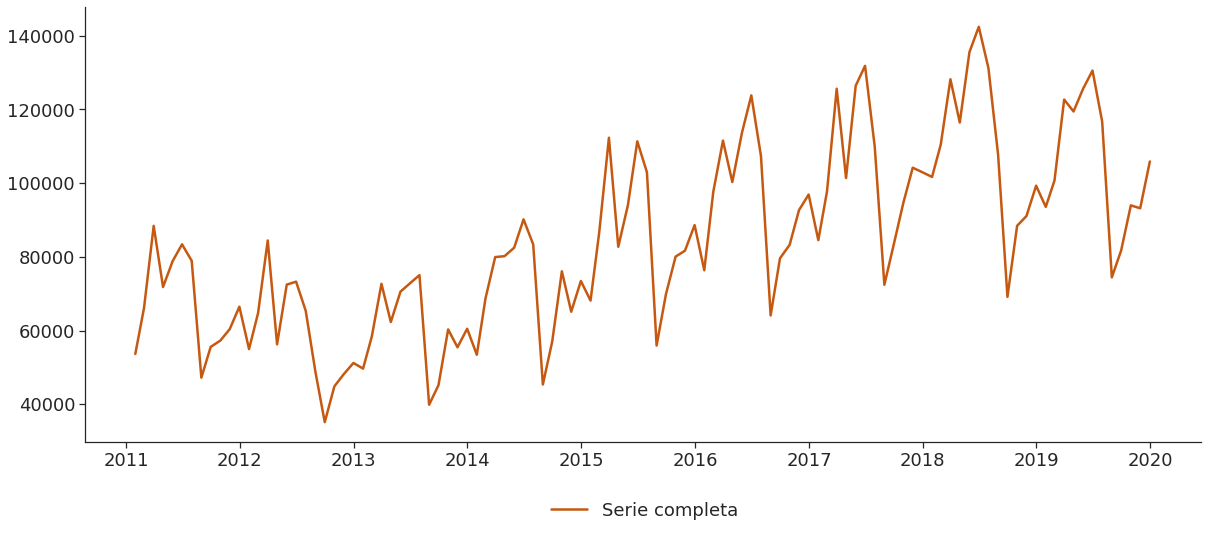

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(month_ts, label="Serie completa", color="#C65911", linewidth=2.5)

plt.legend(bbox_to_anchor=(0.6, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
month_ts.describe().round(2)

count       108.00
mean      84084.12
std       24826.92
min       35143.00
25%       65267.50
50%       82113.00
75%      101441.75
max      142391.00
Name: total, dtype: float64

In [ ]:
# Test de Dickey-Fuller: ¿serie estacionaria? MENSUAL
dftest = adfuller(month_ts)
print('Resultados del test de Dickey-Fuller:')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags usados', 'Observaciones usadas'])
for key, value in dftest[4].items():
  dfoutput['Valor crítico (%s)'%key] = value
print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic          -0.502617
p-value                  0.891505
Lags usados             13.000000
Observaciones usadas    94.000000
Valor crítico (1%)      -3.501912
Valor crítico (5%)      -2.892815
Valor crítico (10%)     -2.583454
dtype: float64


El p-value es mayor que 0.05, porque lo que no se puede rechazar la hipótesis nula y por lo tanto se confirma que la serie no es estacionaria.

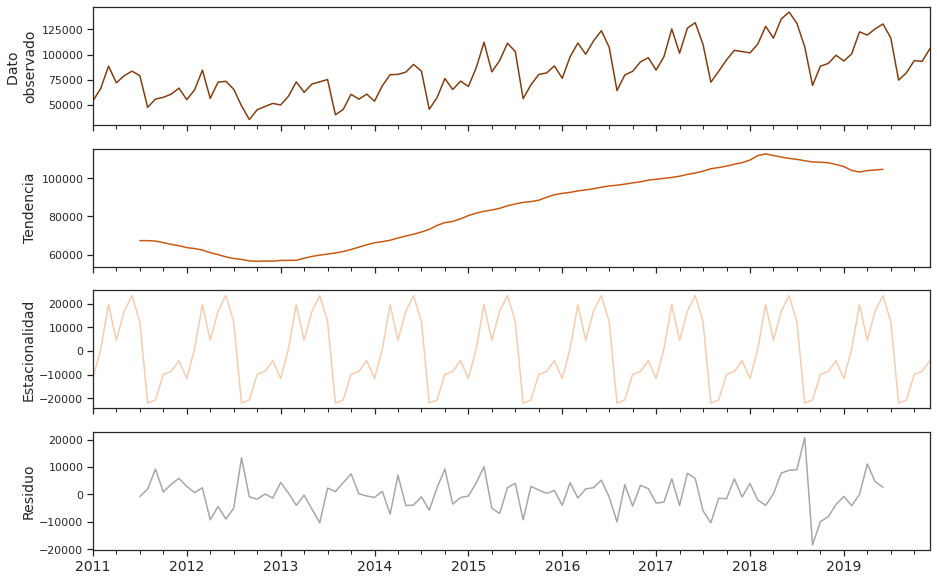

In [ ]:
# Descomposición estacional

rcParams['figure.figsize'] = 15, 10
fig, axes = plt.subplots(4, 1, sharex=True)

result = seasonal_decompose(month_ts, model='additive', period=12)
result.observed.plot(ax=axes[0], legend=False, color='#833C0C', linewidth=1.5)
axes[0].set_ylabel('Dato \nobservado', fontsize=14)
result.trend.plot(ax=axes[1], legend=False, color='#C65911', linewidth=1.5)
axes[1].set_ylabel('Tendencia', fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False, color='#F8CBAD', linewidth=1.5)
axes[2].set_ylabel('Estacionalidad', fontsize=14)
result.resid.plot(ax=axes[3], legend=False, color='#A6A6A6', linewidth=1.5)
axes[3].set_ylabel('Residuo', fontsize=14)

plt.xticks(fontsize=14)
plt.xlabel("")

plt.show()

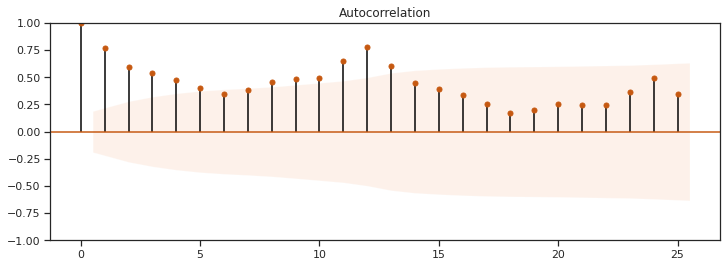

In [ ]:
# Representar la función de autocorrelación
curr_fig, curr_ax = plt.subplots(figsize=(12, 4))

sm.graphics.tsa.plot_acf(month_ts.values.squeeze(), lags=25, ax=curr_ax)

for item in curr_ax.collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor("#F8CBAD")
    #change the color of the vertical lines
    if type(item)==LineCollection:
        item.set_color("black")    

#change the color of the markers/horizontal line
for item in curr_ax.lines:
    item.set_color("#C65911")

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


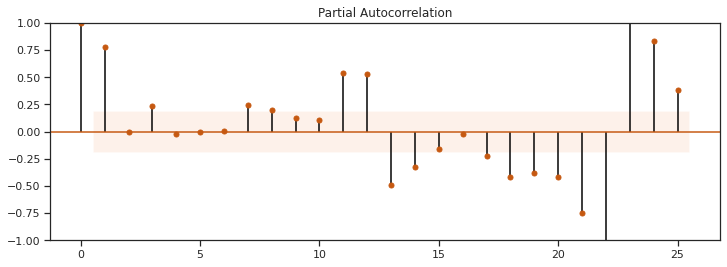

In [ ]:
# Representar la función de autocorrelación parcial
curr_fig, curr_ax = plt.subplots(figsize=(12, 4))

sm.graphics.tsa.plot_pacf(month_ts.values.squeeze(), lags=25, ax=curr_ax)

for item in curr_ax.collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor("#F8CBAD")
    #change the color of the vertical lines
    if type(item)==LineCollection:
        item.set_color("black")    

#change the color of the markers/horizontal line
for item in curr_ax.lines:
    item.set_color("#C65911")

plt.show()

Se observa correlación en el lag 12, es decir, el mismo mes del año anterior.

#####**Análisis descriptivo anual**

In [ ]:
# Dato diario
day_ts = data['total']

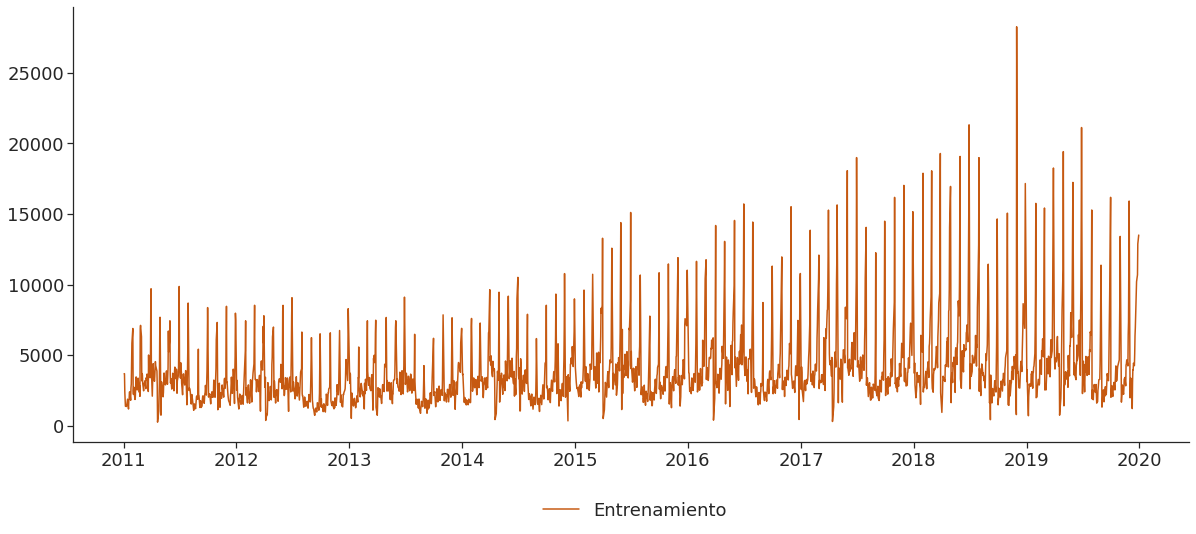

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(day_ts, label="Entrenamiento", color="#C65911", linewidth=1.5)

plt.legend(bbox_to_anchor=(0.6, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
day_ts.describe().round(2)

count     2266.00
mean      4007.54
std       2733.22
min        265.00
25%       2439.75
50%       3294.50
75%       4498.00
max      28252.00
Name: total, dtype: float64

In [ ]:
# Test de Dickey-Fuller: ¿serie estacionaria? MENSUAL
dftest = adfuller(day_ts)
print('Resultados del test de Dickey-Fuller:')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags usados', 'Observaciones usadas'])
for key, value in dftest[4].items():
  dfoutput['Valor crítico (%s)'%key] = value
print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic            -3.182415
p-value                    0.021025
Lags usados               26.000000
Observaciones usadas    2239.000000
Valor crítico (1%)        -3.433274
Valor crítico (5%)        -2.862832
Valor crítico (10%)       -2.567458
dtype: float64


El p-value es mayor que 0.05, porque lo que no se puede rechazar la hipótesis nula y por lo tanto se confirma que la serie no es estacionaria.

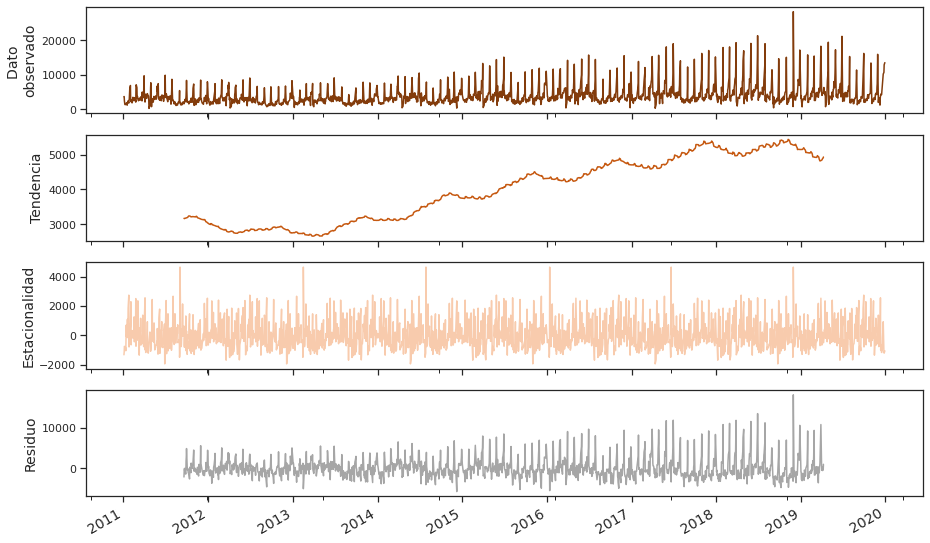

In [ ]:
# Descomposición estacional

rcParams['figure.figsize'] = 15, 10
fig, axes = plt.subplots(4, 1, sharex=True)

result = seasonal_decompose(day_ts, model='additive', period=365)
result.observed.plot(ax=axes[0], legend=False, color='#833C0C', linewidth=1.5)
axes[0].set_ylabel('Dato \nobservado', fontsize=14)
result.trend.plot(ax=axes[1], legend=False, color='#C65911', linewidth=1.5)
axes[1].set_ylabel('Tendencia', fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False, color='#F8CBAD', linewidth=1.5)
axes[2].set_ylabel('Estacionalidad', fontsize=14)
result.resid.plot(ax=axes[3], legend=False, color='#A6A6A6', linewidth=1.5)
axes[3].set_ylabel('Residuo', fontsize=14)

plt.xticks(fontsize=14)
plt.xlabel("")

plt.show()

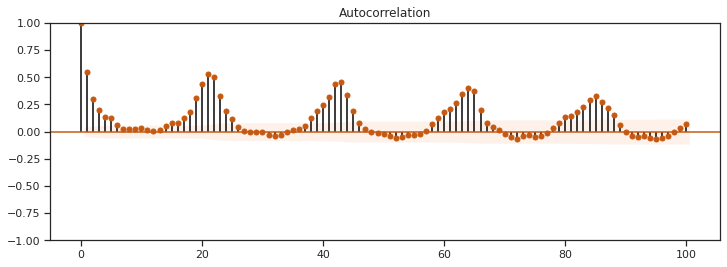

In [ ]:
# Representar la función de autocorrelación
curr_fig, curr_ax = plt.subplots(figsize=(12, 4))

sm.graphics.tsa.plot_acf(day_ts.values.squeeze(), lags=100, ax=curr_ax)

for item in curr_ax.collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor("#F8CBAD")
    #change the color of the vertical lines
    if type(item)==LineCollection:
        item.set_color("black")    

#change the color of the markers/horizontal line
for item in curr_ax.lines:
    item.set_color("#C65911")

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


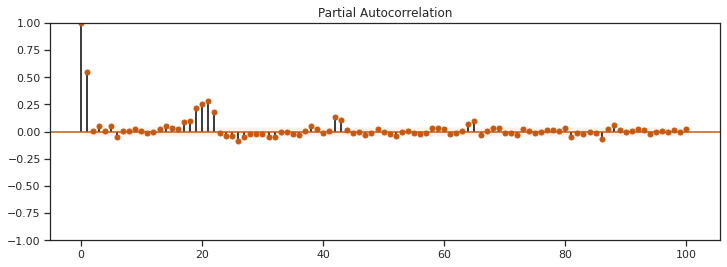

In [ ]:
# Representar la función de autocorrelación parcial
curr_fig, curr_ax = plt.subplots(figsize=(12, 4))

sm.graphics.tsa.plot_pacf(day_ts.values.squeeze(), lags=100, ax=curr_ax)

for item in curr_ax.collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor("#F8CBAD")
    #change the color of the vertical lines
    if type(item)==LineCollection:
        item.set_color("black")    

#change the color of the markers/horizontal line
for item in curr_ax.lines:
    item.set_color("#C65911")

plt.show()

Se observa correlación en el lag 20 y algo (equivalente al mes).

#####**Por canales**

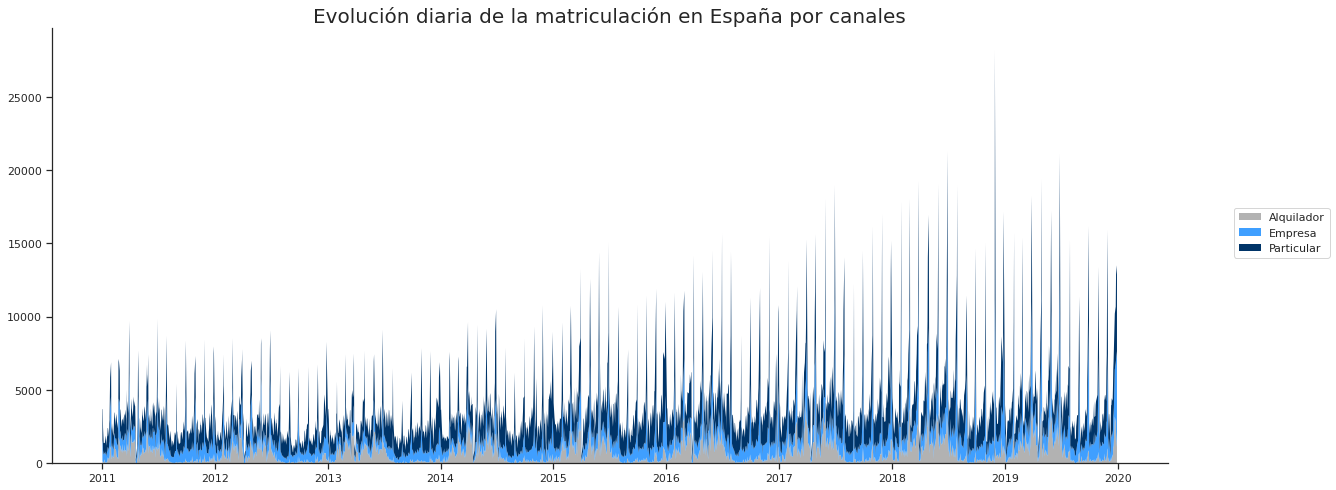

In [ ]:
rcParams['figure.figsize'] = 20, 8

# set seaborn style
sns.set_theme(style="ticks")
colors = ["#B2B2B2", "#3F9FFF", "#003468"]
sns.set_palette(sns.color_palette(colors, as_cmap=False))

# Data
x = data.index
y = [data['ALQUILADOR'], data['EMPRESA'], data['PARTICULAR']]
plt.title('Evolución diaria de la matriculación en España por canales', fontsize=20)
 
# Plot
plt.stackplot(x,y, labels=['Alquilador','Empresa','Particular'],edgecolor='none')
plt.legend(bbox_to_anchor=(1.15, 0.6))

sns.despine() # eliminar eje top y right
plt.show()


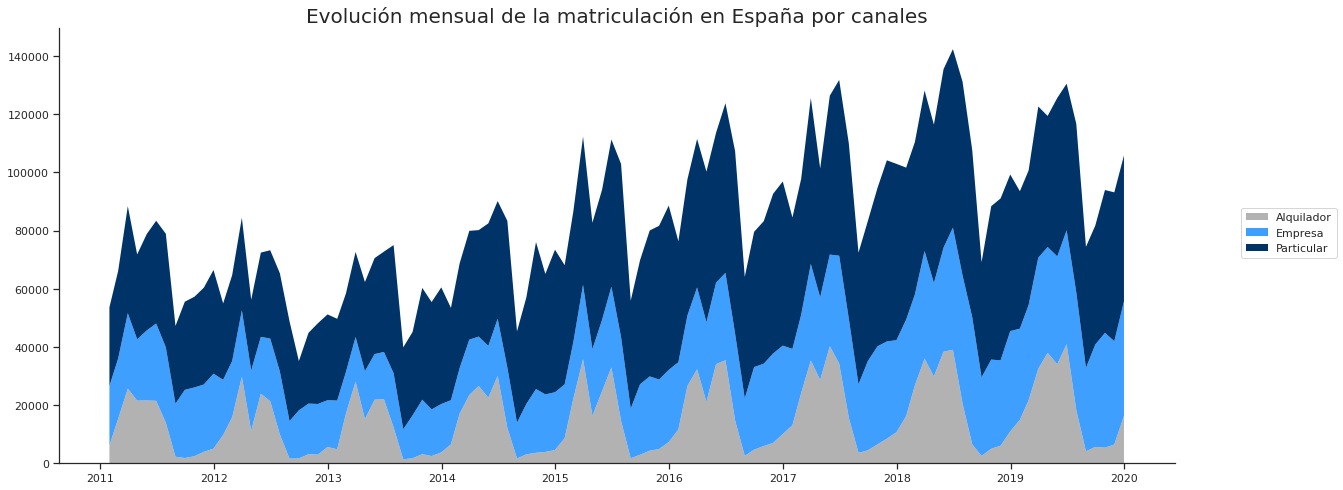

In [ ]:
rcParams['figure.figsize'] = 20, 8

# set seaborn style
sns.set_theme(style="ticks")
colors = ["#B2B2B2", "#3F9FFF", "#003468"]
sns.set_palette(sns.color_palette(colors, as_cmap=False))

# Data
x = data.resample('M').apply(sum).index
y = [data['ALQUILADOR'].resample('M').apply(sum), data['EMPRESA'].resample('M').apply(sum), data['PARTICULAR'].resample('M').apply(sum)]
plt.title('Evolución mensual de la matriculación en España por canales', fontsize=20)

# Plot
plt.stackplot(x,y, labels=['Alquilador','Empresa','Particular'],edgecolor='none')
plt.legend(bbox_to_anchor=(1.15, 0.6))

sns.despine() # eliminar eje top y right
plt.show()

###**<font color=21A5FF>SARIMAX</font>** [datos mensuales, semanales y diarios]

##### **PUNTO DE PARTIDA: Datos mensuales**

In [ ]:
# Mensualizar los datos
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-24)]
validacion = month_ts[int(len(month_ts)-24):]

In [ ]:
# Predicción
%time arima_model = auto_arima(entrenamiento, seasonal=True, m=12)

CPU times: user 4.46 s, sys: 3.17 s, total: 7.63 s
Wall time: 4.02 s


In [ ]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -734.938
Date:                            Wed, 13 Apr 2022   AIC                           1475.876
Time:                                    10:23:36   BIC                           1482.664
Sample:                                         0   HQIC                          1478.576
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3986      0.057     -7.046      0.000      -0.510      -0.288
ma.S.L12      -0.3698      0.079   

In [ ]:
y_arima_forecast = arima_model.predict(n_periods=len(validacion))
y_arima_forecast = pd.DataFrame(y_arima_forecast,index = validacion.index,columns=['Prediction']) # para obtener fechas de las previsiones

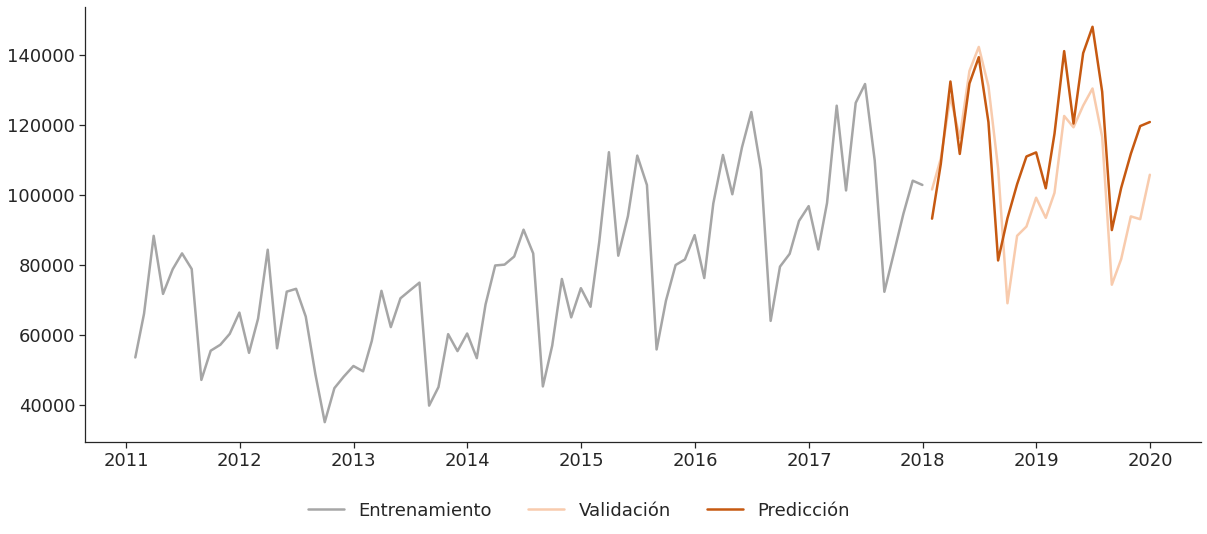

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=2.5)
plt.plot(y_arima_forecast, label="Predicción", color="#C65911", linewidth=2.5)

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_sarima_month_LT = sqrt(mean_squared_error(validacion,y_arima_forecast))
print(rms_sarima_month_LT)

# RMSE - 3 mes
rms_sarima_month_MT = sqrt(mean_squared_error(validacion[:3],y_arima_forecast[:3]))
print(rms_sarima_month_MT)

# RMSE - 1 mes
rms_sarima_month_ST = sqrt(mean_squared_error(validacion[:1],y_arima_forecast[:1]))
print(rms_sarima_month_ST)

15311.004038651248
5510.22570226953
8352.2809481781


##### **Un paso más allá: datos semanales**

In [ ]:
# Datos en semanas
week_ts = data['total'].resample('W').apply(sum)

Entrenamiento: 2011-01-09 00:00:00  -  2018-01-07 00:00:00
Validación:  2018-01-14 00:00:00  -  2020-01-05 00:00:00


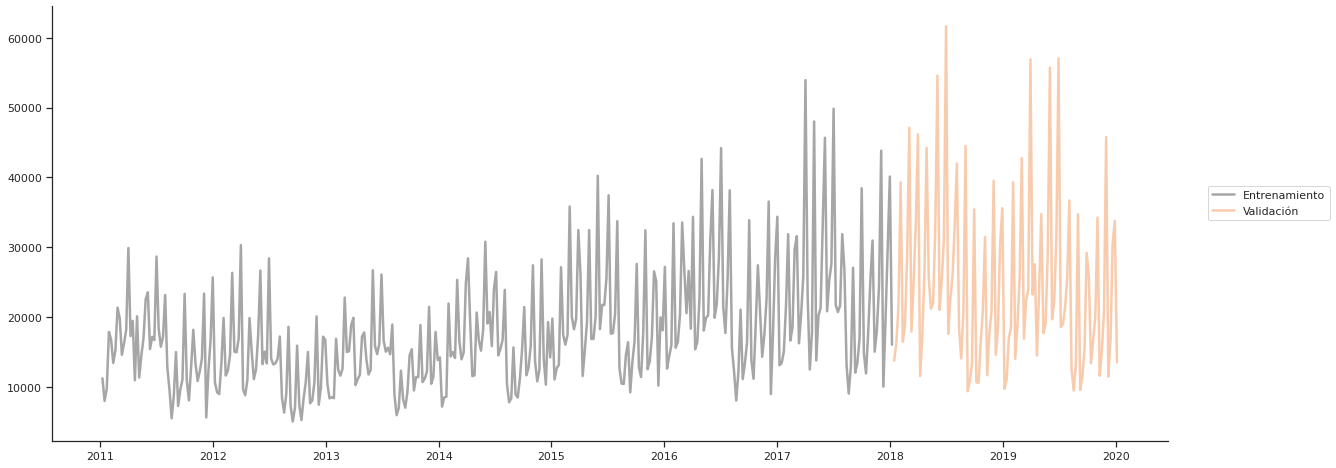

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento = week_ts[:int(len(week_ts)-104)]
validacion = week_ts[int(len(week_ts)-104):]

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=2.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(1.15, 0.6))

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
%time arima_model = auto_arima(week_ts, seasonal=True) #m=52)

CPU times: user 31.6 s, sys: 22.5 s, total: 54.1 s
Wall time: 30.7 s


In [ ]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  470
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -4722.405
Date:                Wed, 13 Apr 2022   AIC                           9466.810
Time:                        10:24:08   BIC                           9512.467
Sample:                             0   HQIC                          9484.774
                                - 470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     28.0245    571.199      0.049      0.961   -1091.506    1147.555
ar.L1         -1.6069      0.035    -46.454      0.000      -1.675      -1.539
ar.L2         -1.4542      0.030    -47.698      0.0

In [ ]:
# Predicción
y_arima_forecast = arima_model.predict(n_periods=len(validacion))
y_arima_forecast = pd.DataFrame(y_arima_forecast,index = validacion.index,columns=['Prediction']) # para obtener fechas de las previsiones

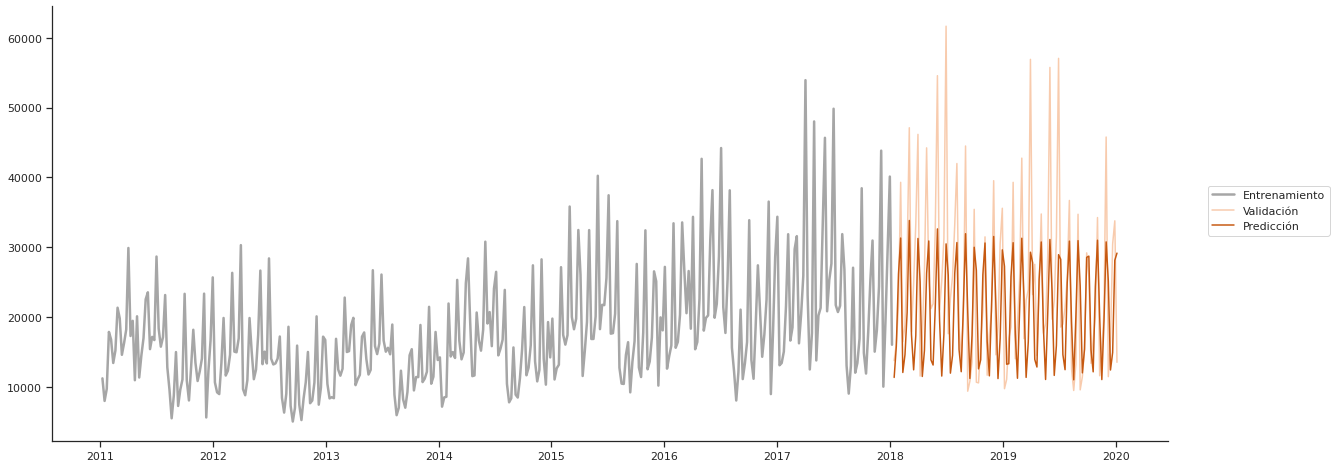

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_forecast, label="Predicción", color="#C65911", linewidth=1.5)

plt.legend(bbox_to_anchor=(1.15, 0.6))

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE
rms_sarima_week = sqrt(mean_squared_error(validacion,y_arima_forecast))
print(rms_sarima_week)

10198.315343037364


##### **El problema de los datos diarios**

Los modelos SARIMA tienen dos desventajas principalmente:

1. Solo puede modelizar un único efecto estacional
2. La longitud de la estacionalidad no debe ser demasiado larga.

Se ignorará la estacionalidad anual (problema de fijar la estacionalidad en 365) para centrarnos en la estaiconalidad semanal.

In [ ]:
# Dato diario
day_ts = data['total']

In [ ]:
date_cut = '2017-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
%time arima_model = auto_arima(entrenamiento, seasonal=True, m=7)

CPU times: user 2min 37s, sys: 1min 52s, total: 4min 30s
Wall time: 2min 18s


In [ ]:
print(arima_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1763
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood              -15743.566
Date:                                Wed, 13 Apr 2022   AIC                          31499.132
Time:                                        10:26:27   BIC                          31531.977
Sample:                                             0   HQIC                         31511.270
                                               - 1763                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9028      0.010    -91.709      0.000      -0.922      -0.884
ar.

In [ ]:
# Predicción
y_arima_forecast = arima_model.predict(n_periods=len(validacion))
y_arima_forecast = pd.DataFrame(y_arima_forecast,index = validacion.index,columns=['Prediction']) # para obtener fechas de las previsiones

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


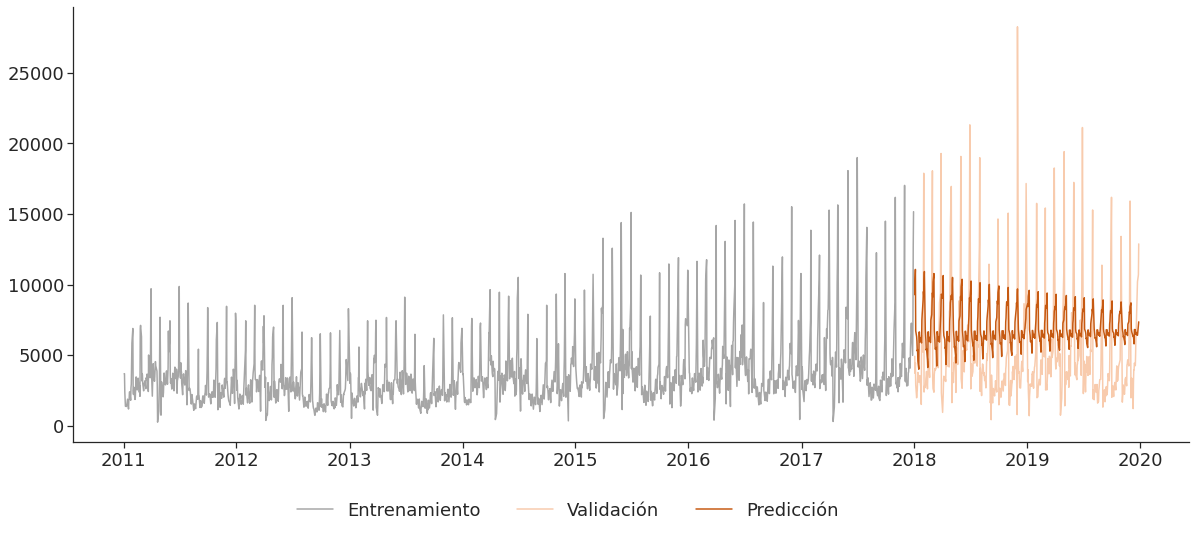

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_sarima_day_LT = sqrt(mean_squared_error(validacion,y_arima_forecast))
print(rms_sarima_day_LT)

# RMSE - 3 mes
rms_sarima_day_MT = sqrt(mean_squared_error(validacion[:66],y_arima_forecast[:66]))
print(rms_sarima_day_MT)

# RMSE - 1 mes
rms_sarima_day_ST = sqrt(mean_squared_error(validacion[:22],y_arima_forecast[:22]))
print(rms_sarima_day_ST)

3938.074577067761
4383.382530475312
3936.405177337275


###**<font color=21A5FF>SARIMAX with Fourier terms</font>**

#####**Dato diario**

In [ ]:
# Dato diario
day_ts = data['total']

In [ ]:
# Preparar los términos de Fourier para añadirlos como variables exógenas al ARIMA
# Se cubre la estacionalidad anual con los términos de Fourier
four_terms = FourierFeaturizer(365.25, 4)
y_prime, exog_365 = four_terms.fit_transform(day_ts)
exog_365['date_matric'] = y_prime.index 
exog_365 = exog_365.set_index(exog_365['date_matric'])
#exog.index.freq = 'D'
exog_365 = exog_365.drop(columns=['date_matric'])

In [ ]:
# Preparar los términos de Fourier para añadirlos como variables exógenas al ARIMA
# Se cubre la estacionalidad mensual con los términos de Fourier
four_terms = FourierFeaturizer(30, 4)
y_prime, exog_30 = four_terms.fit_transform(day_ts)
exog_30['date_matric'] = y_prime.index 
exog_30 = exog_30.set_index(exog_30['date_matric'])
#exog.index.freq = 'D'
exog_30 = exog_30.drop(columns=['date_matric'])

In [ ]:
date_cut = '2017-12-31'
start_en = y_prime.index.searchsorted(pd.to_datetime(min(y_prime.index)))
end_en = y_prime.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = y_prime.iloc[start_en:end_en]
start_va = y_prime.index.searchsorted(pd.to_datetime(date_cut))
end_va = y_prime.index.searchsorted(pd.to_datetime(max(y_prime.index)))
validacion = y_prime.iloc[start_va:end_va]

start_en = exog_365.index.searchsorted(pd.to_datetime(min(exog_365.index)))
end_en = exog_365.index.searchsorted(pd.to_datetime(date_cut))
exog_365_entrenamiento = exog_365.iloc[start_en:end_en]
start_va = exog_365.index.searchsorted(pd.to_datetime(date_cut))
end_va = exog_365.index.searchsorted(pd.to_datetime(max(exog_365.index)))
exog_365_validacion = exog_365.iloc[start_va:end_va]

start_en = exog_30.index.searchsorted(pd.to_datetime(min(exog_30.index)))
end_en = exog_30.index.searchsorted(pd.to_datetime(date_cut))
exog_30_entrenamiento = exog_30.iloc[start_en:end_en]
start_va = exog_30.index.searchsorted(pd.to_datetime(date_cut))
end_va = exog_30.index.searchsorted(pd.to_datetime(max(exog_30.index)))
exog_30_validacion = exog_30.iloc[start_va:end_va]

exog_entrenamiento = exog_365_entrenamiento.merge(exog_30_entrenamiento, on='date_matric')
exog_validacion = exog_365_validacion.merge(exog_30_validacion, on='date_matric')

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


In [ ]:
%time arima_exog_model = auto_arima(y=entrenamiento, exogenous=exog_entrenamiento, seasonal=True, m=7)

CPU times: user 30min 9s, sys: 33min 2s, total: 1h 3min 12s
Wall time: 32min 24s


In [ ]:
print(arima_exog_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1763
Model:             SARIMAX(2, 1, 5)x(2, 0, [1, 2], 7)   Log Likelihood              -15656.355
Date:                                Wed, 13 Apr 2022   AIC                          31370.709
Time:                                        10:58:51   BIC                          31529.461
Sample:                                             0   HQIC                         31429.374
                                               - 1763                                         
Covariance Type:                                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         15.1133     42.174      0.358      0.720     -67.546    

In [ ]:
# Predicción
y_arima_exog_forecast = arima_exog_model.predict(n_periods=len(validacion), exogenous=exog_validacion)
y_arima_exog_forecast = pd.DataFrame(y_arima_exog_forecast, index = validacion.index, columns=['Prediction']) # para obtener fechas de las previsiones

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


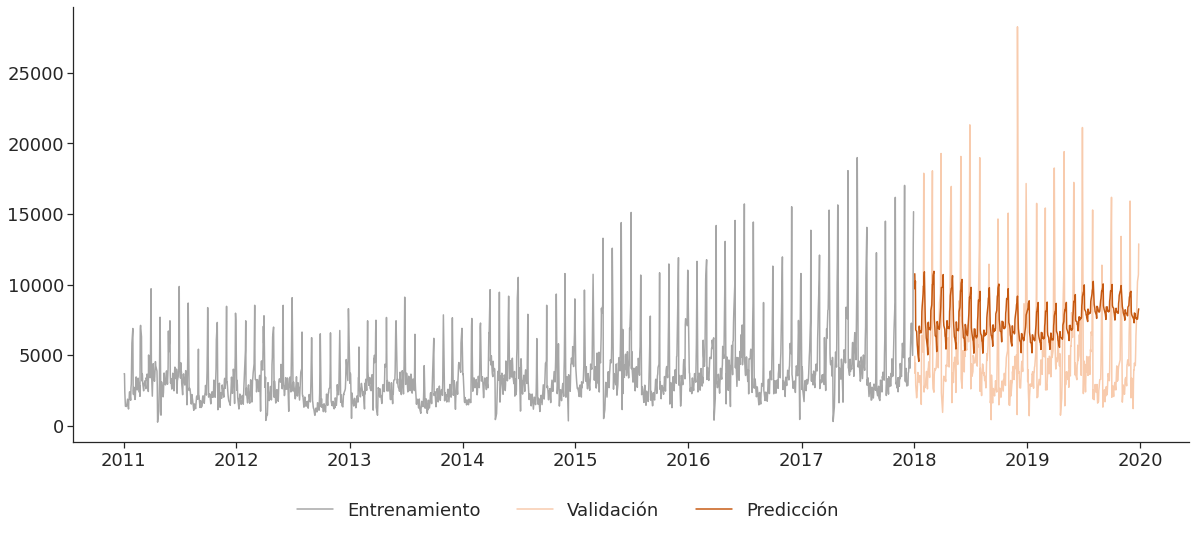

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_exog_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_sarimafourier_day_LT = sqrt(mean_squared_error(validacion,y_arima_exog_forecast))
print(rms_sarimafourier_day_LT)

# RMSE - 3 mes
rms_sarimafourier_day_MT = sqrt(mean_squared_error(validacion[:66],y_arima_exog_forecast[:66]))
print(rms_sarimafourier_day_MT)

# RMSE - 1 mes
rms_sarimafourier_day_ST = sqrt(mean_squared_error(validacion[:22],y_arima_exog_forecast[:22]))
print(rms_sarimafourier_day_ST)

4329.521359030345
4576.663222000726
4083.500421017291


#####**Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


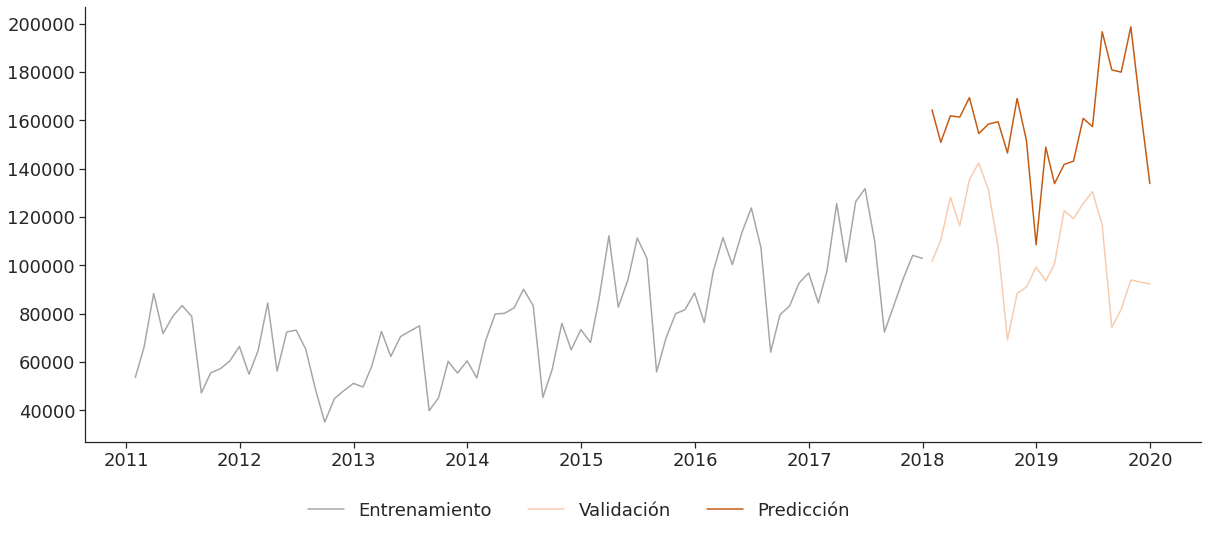

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_exog_forecast.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_sarimafourier_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum),y_arima_exog_forecast.resample('M').apply(sum)))
print(rms_sarimafourier_month_LT)

# RMSE - 3 mes
rms_sarimafourier_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:3],y_arima_exog_forecast.resample('M').apply(sum)[:3]))
print(rms_sarimafourier_month_MT)

# RMSE - 1 mes
rms_sarimafourier_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:1],y_arima_exog_forecast.resample('M').apply(sum)[:1]))
print(rms_sarimafourier_month_ST)

58505.99337171897
47311.15491829537
62737.416533689364


###**<font color=21A5FF>Holt-Winters</font>**

#####**Previo**

In [ ]:
# Utilziar el periodo completo
periodo_completo = pd.DataFrame({'date_matric': pd.date_range(start = data.index.min(),
                                                              end = data.index.max(),
                                                              freq='D')})

day_ts = periodo_completo.merge(data['total'], how='outer', on='date_matric')
day_ts['total'] = day_ts['total'].fillna(1)

day_ts = day_ts.set_index('date_matric')
day_ts.head()

,total
date_matric,
2011-01-03,3695.0
2011-01-04,3693.0
2011-01-05,2424.0
2011-01-06,1.0
2011-01-07,1394.0


In [ ]:
date_cut = '2018-01-01'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Fijar valor de Alpha y definir el periodo temporal
m = 365
alpha = 1/(2*365)

#####**Prueba: suavizado simple (Single Exponential Smoothing)**

El suavizado siempre no funciona cuando el conjuto de datos está afectado tanto por tendencia y estacionalidad.

In [ ]:
model_HWES1 = SimpleExpSmoothing(entrenamiento).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


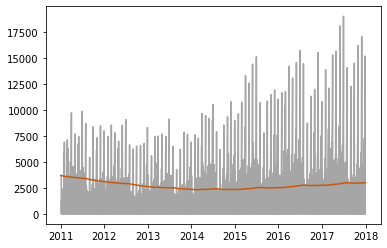

In [ ]:
plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(model_HWES1, label="Modelo", color="#C65911", linewidth=1.5)

#####**Prueba: suavizado doble (Double Exponential Smoothing)**

El siguiente paso es probar con el suavizado doble en ambos formatos posibles (adivitvo y multiplicativo). FUncionará mejor pero será con el triple suavizado cuando se termine de modelizar correctamente la estacionalidad de la serie.

In [ ]:
model_HWES2_ADD = ExponentialSmoothing(entrenamiento,trend='add').fit().fittedvalues
model_HWES2_MUL = ExponentialSmoothing(entrenamiento,trend='mul').fit().fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


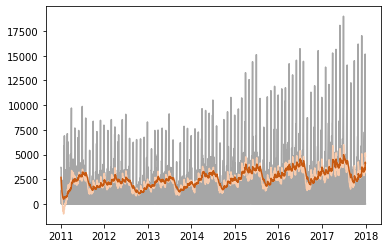

In [ ]:
plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(model_HWES2_ADD, label="Modelo aditivo", color="#F8CBAD", linewidth=1.5)
plt.plot(model_HWES2_MUL, label="Modelo multiplicativo", color="#C65911", linewidth=1.5)

##### **Datos diarios**

In [ ]:
print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-01 00:00:00  -  2019-12-29 00:00:00


In [ ]:
%time model_HWES3_ADD_ADD = ExponentialSmoothing(entrenamiento,trend='add',seasonal='add',seasonal_periods=365, damped_trend = False).fit()

forecast_HW_ADD_ADD = model_HWES3_ADD_ADD.forecast(len(validacion))
forecast_HW_ADD_ADD = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_ADD.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_ADD = forecast_HW_ADD_ADD.set_index('date_matric')
forecast_HW_ADD_ADD = forecast_HW_ADD_ADD[forecast_HW_ADD_ADD.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


CPU times: user 789 ms, sys: 3.94 ms, total: 793 ms
Wall time: 841 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_MUL = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='mul',seasonal_periods=365, damped_trend = True).fit()

forecast_HW_MUL_MUL = model_HWES3_MUL_MUL.forecast(len(validacion))
forecast_HW_MUL_MUL = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_MUL.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_MUL = forecast_HW_MUL_MUL.set_index('date_matric')
forecast_HW_MUL_MUL = forecast_HW_MUL_MUL[forecast_HW_MUL_MUL.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


CPU times: user 53 s, sys: 168 ms, total: 53.1 s
Wall time: 58.5 s


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_ADD_MUL = ExponentialSmoothing(entrenamiento,trend='add',seasonal='mul',seasonal_periods=365, damped_trend = True).fit()

forecast_HW_ADD_MUL = model_HWES3_ADD_MUL.forecast(len(validacion))
forecast_HW_ADD_MUL = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_MUL.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_MUL = forecast_HW_ADD_MUL.set_index('date_matric')
forecast_HW_ADD_MUL = forecast_HW_ADD_MUL[forecast_HW_ADD_MUL.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


CPU times: user 1.37 s, sys: 7.04 ms, total: 1.38 s
Wall time: 1.37 s


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_ADD = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='ADD',seasonal_periods=365, damped_trend = False).fit()

forecast_HW_MUL_ADD = model_HWES3_MUL_ADD.forecast(len(validacion))
forecast_HW_MUL_ADD = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_ADD.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_ADD = forecast_HW_MUL_ADD.set_index('date_matric')
forecast_HW_MUL_ADD = forecast_HW_MUL_ADD[forecast_HW_MUL_ADD.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


CPU times: user 1.04 s, sys: 8.07 ms, total: 1.05 s
Wall time: 1.06 s


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

In [ ]:
# RMSE - 2 años
rms_HW_ADD_ADD_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_ADD_ADD))
rms_HW_MUL_MUL_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_MUL_MUL))
rms_HW_ADD_MUL_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_ADD_MUL))
rms_HW_MUL_ADD_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_MUL_ADD))

print("ADD-ADD:", rms_HW_ADD_ADD_day_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_day_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_day_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_day_LT)

ADD-ADD: 3115.3979588669577
MUL-MUL: 32074.286232926537
ADD-MUL: 27181.029360729484
MUL-ADD: 3093.107801117553


In [ ]:
# RMSE - 3 meses
rms_HW_ADD_ADD_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_ADD_ADD[:66]))
rms_HW_MUL_MUL_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_MUL_MUL[:66]))
rms_HW_ADD_MUL_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_ADD_MUL[:66]))
rms_HW_MUL_ADD_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_MUL_ADD[:66]))

print("ADD-ADD:", rms_HW_ADD_ADD_day_MT)
print("MUL-MUL:", rms_HW_MUL_MUL_day_MT)
print("ADD-MUL:", rms_HW_ADD_MUL_day_MT)
print("MUL-ADD:", rms_HW_MUL_ADD_day_MT)

ADD-ADD: 3789.2000084138185
MUL-MUL: 32550.57890965263
ADD-MUL: 27745.444716503243
MUL-ADD: 3782.9098592223477


In [ ]:
# RMSE - 1 mes
rms_HW_ADD_ADD_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_ADD_ADD[:22]))
rms_HW_MUL_MUL_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_MUL_MUL[:22]))
rms_HW_ADD_MUL_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_ADD_MUL[:22]))
rms_HW_MUL_ADD_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_MUL_ADD[:22]))

print("ADD-ADD:", rms_HW_ADD_ADD_day_ST)
print("MUL-MUL:", rms_HW_MUL_MUL_day_ST)
print("ADD-MUL:", rms_HW_ADD_MUL_day_ST)
print("MUL-ADD:", rms_HW_MUL_ADD_day_ST)

ADD-ADD: 1807.114153433684
MUL-MUL: 27752.462875292742
ADD-MUL: 23698.03368620386
MUL-ADD: 1800.8034932307382


Entrenamiento: 2011-01-03 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-01 00:00:00  -  2019-12-29 00:00:00


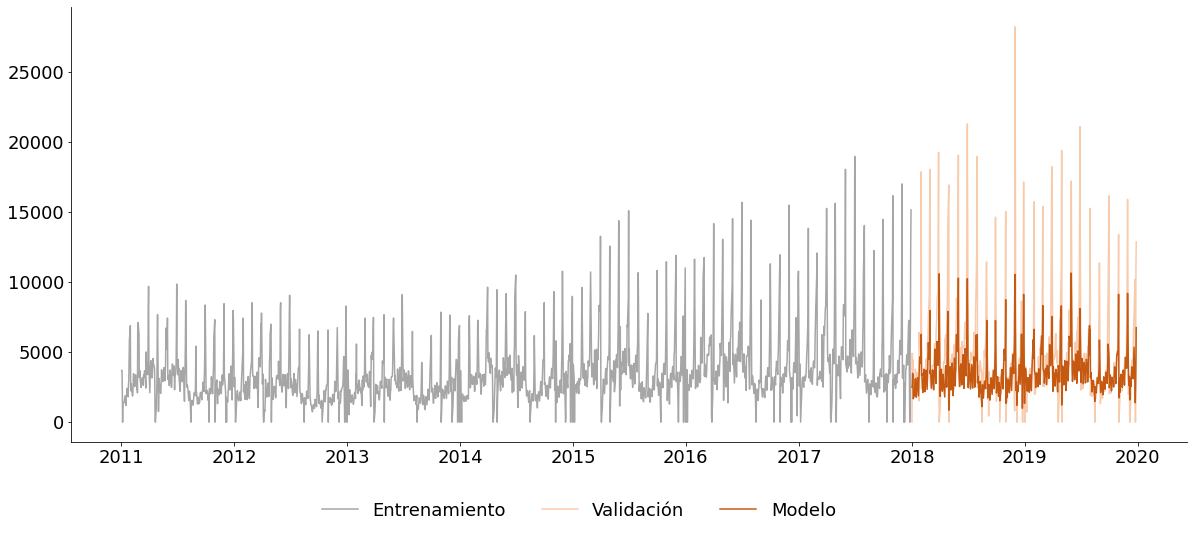

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

plt.plot(entrenamiento_sinfindes, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_HW_MUL_ADD, label="Modelo", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

#####**Mensualizar**

In [ ]:
# RMSE - 2 años
rms_HW_ADD_ADD_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_ADD_ADD.resample('M').apply(sum)))
rms_HW_MUL_MUL_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_MUL_MUL.resample('M').apply(sum)))
rms_HW_ADD_MUL_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_ADD_MUL.resample('M').apply(sum)))
rms_HW_MUL_ADD_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_MUL_ADD.resample('M').apply(sum)))

print("ADD-ADD:", rms_HW_ADD_ADD_month_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_LT)

ADD-ADD: 32198.052882791584
MUL-MUL: 605812.9929287471
ADD-MUL: 512047.41057873715
MUL-ADD: 31211.383693899097


In [ ]:
# RMSE - 3 meses
rms_HW_ADD_ADD_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_ADD_ADD.resample('M').apply(sum)[:3]))
rms_HW_MUL_MUL_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_MUL_MUL.resample('M').apply(sum)[:3]))
rms_HW_ADD_MUL_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_ADD_MUL.resample('M').apply(sum)[:3]))
rms_HW_MUL_ADD_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_MUL_ADD.resample('M').apply(sum)[:3]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_MT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_MT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_MT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_MT)

ADD-ADD: 34389.14206387452
MUL-MUL: 592798.3618429695
ADD-MUL: 502601.80123550264
MUL-ADD: 34069.77180580387


In [ ]:
# RMSE - 1 mes
rms_HW_ADD_ADD_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_ADD_ADD.resample('M').apply(sum)[:1]))
rms_HW_MUL_MUL_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_MUL_MUL.resample('M').apply(sum)[:1]))
rms_HW_ADD_MUL_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_ADD_MUL.resample('M').apply(sum)[:1]))
rms_HW_MUL_ADD_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_MUL_ADD.resample('M').apply(sum)[:1]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_ST)
print("MUL-MUL:", rms_HW_MUL_MUL_month_ST)
print("ADD-MUL:", rms_HW_ADD_MUL_month_ST)
print("MUL-ADD:", rms_HW_MUL_ADD_month_ST)

ADD-ADD: 31418.86649837323
MUL-MUL: 492333.2919681147
ADD-MUL: 416259.3692378551
MUL-ADD: 31136.601028973644


Entrenamiento: 2011-01-03 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-01 00:00:00  -  2019-12-29 00:00:00


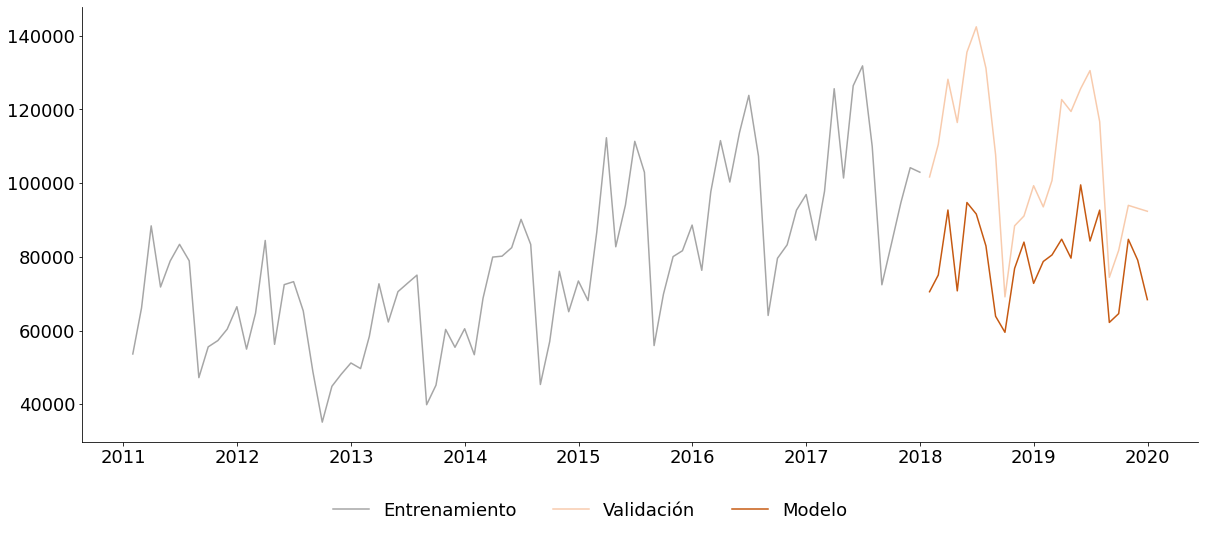

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_sinfindes.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_HW_MUL_ADD.resample('M').apply(sum), label="Modelo", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-24)]
validacion = month_ts[int(len(month_ts)-24):]

In [ ]:
%time model_HWES3_ADD_ADD_mes = ExponentialSmoothing(entrenamiento,trend='add',seasonal='add',seasonal_periods=12, damped_trend = True).fit()

forecast_HW_ADD_ADD_mes = model_HWES3_ADD_ADD_mes.forecast(len(validacion))
forecast_HW_ADD_ADD_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_ADD_mes.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_ADD_mes = forecast_HW_ADD_ADD_mes.set_index('date_matric')

CPU times: user 118 ms, sys: 1.99 ms, total: 120 ms
Wall time: 146 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_MUL_mes = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='mul',seasonal_periods=12, damped_trend = True).fit()

forecast_HW_MUL_MUL_mes = model_HWES3_MUL_MUL_mes.forecast(len(validacion))
forecast_HW_MUL_MUL_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_MUL_mes.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_MUL_mes = forecast_HW_MUL_MUL_mes.set_index('date_matric')

CPU times: user 470 ms, sys: 960 µs, total: 471 ms
Wall time: 499 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_ADD_MUL_mes = ExponentialSmoothing(entrenamiento,trend='add',seasonal='mul',seasonal_periods=12, damped_trend = True).fit()

forecast_HW_ADD_MUL_mes = model_HWES3_ADD_MUL_mes.forecast(len(validacion))
forecast_HW_ADD_MUL_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_MUL_mes.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_MUL_mes = forecast_HW_ADD_MUL_mes.set_index('date_matric')

CPU times: user 126 ms, sys: 3 ms, total: 129 ms
Wall time: 139 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_ADD_mes = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='ADD',seasonal_periods=12, damped_trend = True).fit()

forecast_HW_MUL_ADD_mes = model_HWES3_MUL_ADD_mes.forecast(len(validacion))
forecast_HW_MUL_ADD_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_ADD_mes.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_ADD_mes = forecast_HW_MUL_ADD_mes.set_index('date_matric')

CPU times: user 383 ms, sys: 3 ms, total: 386 ms
Wall time: 415 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
# RMSE - 2 años
rms_HW_ADD_ADD_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_ADD_ADD_mes))
rms_HW_MUL_MUL_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_MUL_MUL_mes))
rms_HW_ADD_MUL_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_ADD_MUL_mes))
rms_HW_MUL_ADD_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_MUL_ADD_mes))

print("ADD-ADD:", rms_HW_ADD_ADD_month_2_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_2_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_2_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_2_LT)

ADD-ADD: 13407.476379699749
MUL-MUL: 23736.622083082064
ADD-MUL: 20291.29681853053
MUL-ADD: 14229.539392851973


In [ ]:
# RMSE - 3 meses
rms_HW_ADD_ADD_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_ADD_ADD_mes[:3]))
rms_HW_MUL_MUL_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_MUL_MUL_mes[:3]))
rms_HW_ADD_MUL_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_ADD_MUL_mes[:3]))
rms_HW_MUL_ADD_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_MUL_ADD_mes[:3]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_2_MT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_2_MT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_2_MT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_2_MT)

ADD-ADD: 4464.456162535653
MUL-MUL: 12647.7795587751
ADD-MUL: 12115.410760351613
MUL-ADD: 4486.939326344834


In [ ]:
# RMSE - 1 mes
rms_HW_ADD_ADD_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_ADD_ADD_mes[:1]))
rms_HW_MUL_MUL_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_MUL_MUL_mes[:1]))
rms_HW_ADD_MUL_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_ADD_MUL_mes[:1]))
rms_HW_MUL_ADD_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_MUL_ADD_mes[:1]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_2_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_2_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_2_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_2_LT)

ADD-ADD: 7156.018132235593
MUL-MUL: 6827.334713720455
ADD-MUL: 7133.919685627014
MUL-ADD: 7073.354770512204


Entrenamiento: 2011-01-31 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-31 00:00:00  -  2019-12-31 00:00:00


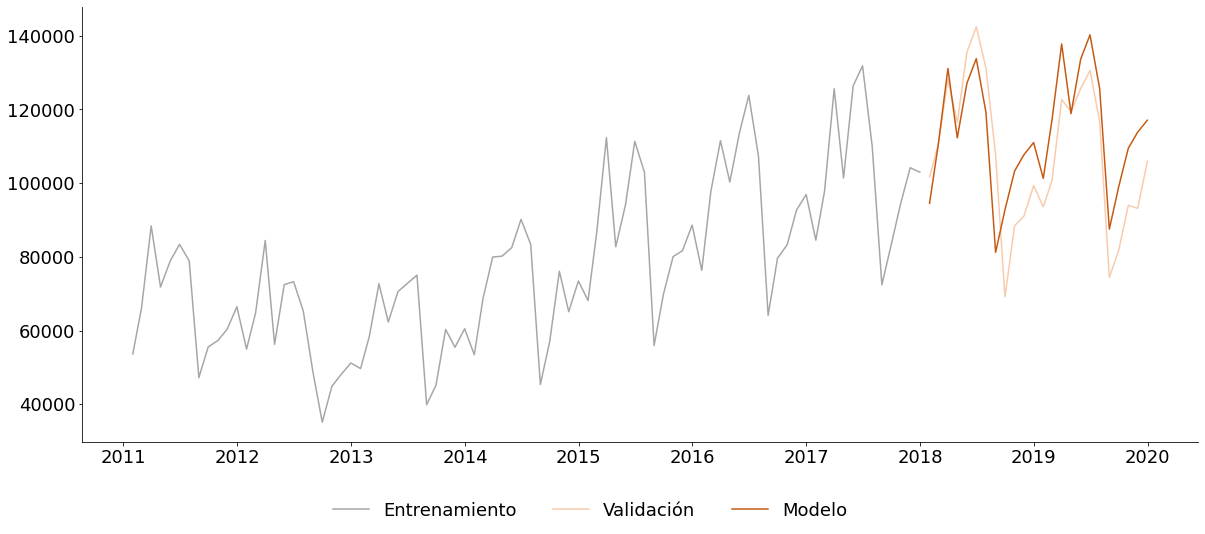

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_HW_ADD_ADD_mes, label="Modelo", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

### **<font color=21A5FF>TBATS</font>**

#####**Dato diario**

In [ ]:
# Completar datos con filas vacías (necesario para TBATS)
periodo_completo = pd.DataFrame({'date_matric': pd.date_range(start = data.index.min(),
                                                              end = data.index.max(),
                                                              freq='D')})

day_ts = periodo_completo.merge(data['total'], how='outer', on='date_matric')
day_ts['total'] = day_ts['total'].fillna(0)

day_ts = day_ts.set_index('date_matric')
day_ts.head()

,total
date_matric,
2011-01-03,3695.0
2011-01-04,3693.0
2011-01-05,2424.0
2011-01-06,0.0
2011-01-07,1394.0


In [ ]:
date_cut = '2018-01-01'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Entrenar el modelo
estimator = TBATS(seasonal_periods=[7, 30.5, 365.25])

%time smodel = estimator.fit(entrenamiento)

print('\n' + smodel.summary())

CPU times: user 18.8 s, sys: 1.52 s, total: 20.3 s
Wall time: 11min 18s

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.    30.5  365.25]
Seasonal harmonics [3 5 4]
ARMA errors (p, q): (1, 2)
Smoothing (Alpha): 0.008813
Seasonal Parameters (Gamma): [-1.31079210e-04  2.95524941e-05 -5.53058095e-04  2.09814696e-04
  3.13273475e-04 -4.52890939e-04]
AR coefficients [0.00020981]
MA coefficients [ 0.00031327 -0.00045289]
Seed vector [2171.48578831 -883.13990836 1070.91682734  105.94375854 1764.59606309
  483.73794158 -429.06454154 -332.42831707 -528.14389833  106.71465584
  164.38532123 -108.4612731  -870.17452972  114.14254605  329.83203919
 -128.74427677  -46.512092   -151.55202027  133.53448594 -337.27252995
  105.0329515   527.59476529 -188.81248177   59.39864914 -145.12914441
    0.            0.            0.        ]

AIC 57864.488168


In [ ]:
# Predicción
tbats_forecast_day = smodel.forecast(steps=len(validacion))
tbats_forecast_day = pd.DataFrame(tbats_forecast_day,index = validacion.index,columns=['Prediction']) # Para obtener fechas de las previsiones
tbats_forecast_day = tbats_forecast_day[tbats_forecast_day.index.dayofweek < 5] # Eliminar los fines de semana

# Análisis
#print(smodel.y_hat) # in sample prediction
#print(smodel.resid) # in sample residuals
#print(smodel.aic)

# Leer parámetros del modelo
#print(smodel.params.alpha)
#print(smodel.params.beta)
#print(smodel.params.x0)
#print(smodel.params.components.use_box_cox)
#print(smodel.params.components.seasonal_harmonics)

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-01 00:00:00  -  2019-12-29 00:00:00


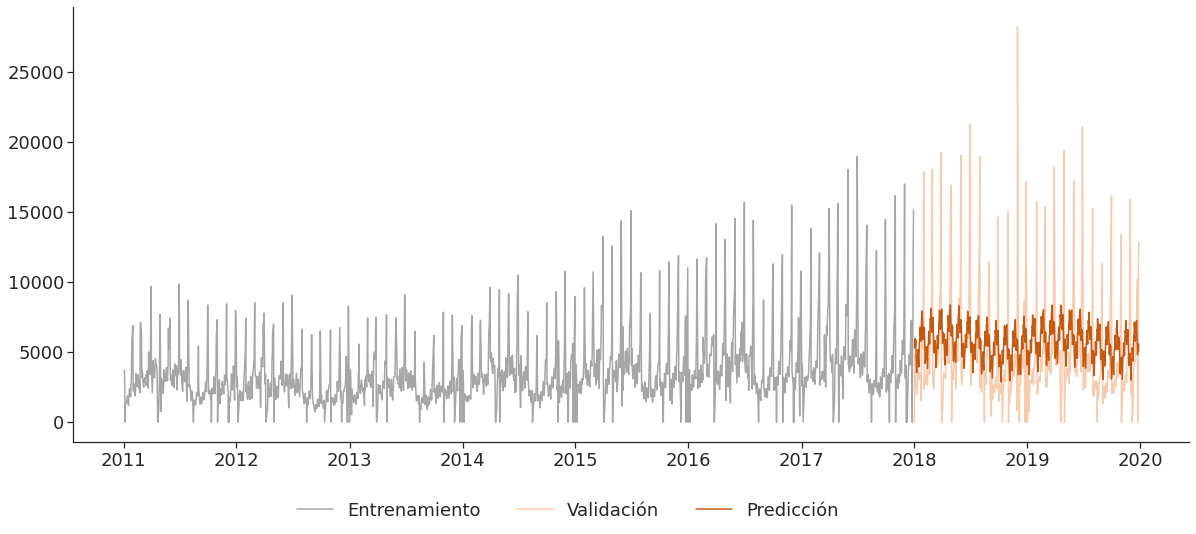

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

plt.plot(entrenamiento_sinfindes, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(tbats_forecast_day, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_tbats_day_LT = sqrt(mean_squared_error(validacion_sinfindes,tbats_forecast_day))
print(rms_tbats_day_LT)

# RMSE - 3 meses
rms_tbats_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],tbats_forecast_day[:66]))
print(rms_tbats_day_MT)

# RMSE - 1 mes
rms_tbats_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],tbats_forecast_day[:22]))
print(rms_tbats_day_ST)

3669.756038113572
3647.823636656512
2641.850236485761


#####**Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-01 00:00:00  -  2019-12-29 00:00:00


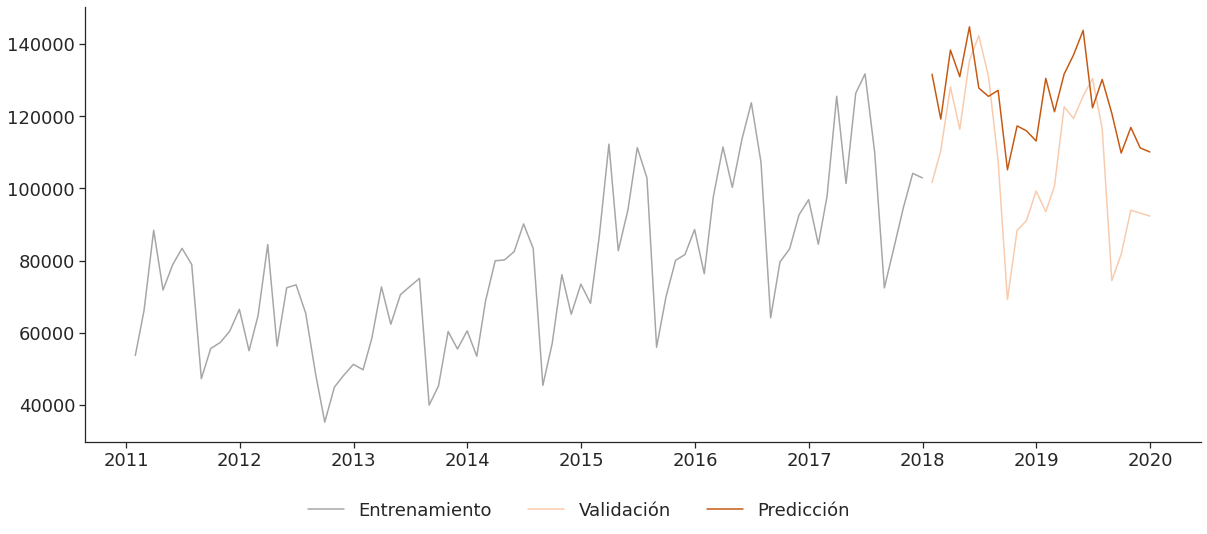

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

plt.plot(entrenamiento_sinfindes.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(tbats_forecast_day.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_tbats_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),tbats_forecast_day.resample('M').apply(sum)))
print(rms_tbats_month_LT)

# RMSE - 3 meses
rms_tbats_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],tbats_forecast_day.resample('M').apply(sum)[:3]))
print(rms_tbats_month_MT)

# RMSE - 1 mes
rms_tbats_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],tbats_forecast_day.resample('M').apply(sum)[:1]))
print(rms_tbats_month_ST)

22214.236505273024
19004.517979764485
30027.225495177758


#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-24)]
validacion = month_ts[int(len(month_ts)-24):]

In [ ]:
# Entrenar el modelo
estimator = TBATS(seasonal_periods=[12], use_trend=True, use_damped_trend=False)

%time smodel = estimator.fit(entrenamiento)

print('\n' + smodel.summary())

CPU times: user 531 ms, sys: 316 ms, total: 847 ms
Wall time: 19.9 s

Use Box-Cox: True
Use trend: True
Use damped trend: False
Seasonal periods: [12.]
Seasonal harmonics [5]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.322566
Smoothing (Alpha): 0.214869
Trend (Beta): 0.058908
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [-0.01125041  0.01269063]
AR coefficients []
MA coefficients []
Seed vector [111.37779487   0.31775992  -0.72278765  -0.35588463  -3.37667168
  -0.45398228  -1.75380653   7.03994703  -3.40085544   3.16522843
  -2.45489921  -1.2245932 ]

AIC 1845.441560


In [ ]:
# Predicción
tbats_forecast_month_2 = smodel.forecast(steps=len(validacion))
tbats_forecast_month_2 = pd.DataFrame(tbats_forecast_month_2,index = validacion.index,columns=['Prediction']) # Para obtener fechas de las previsiones

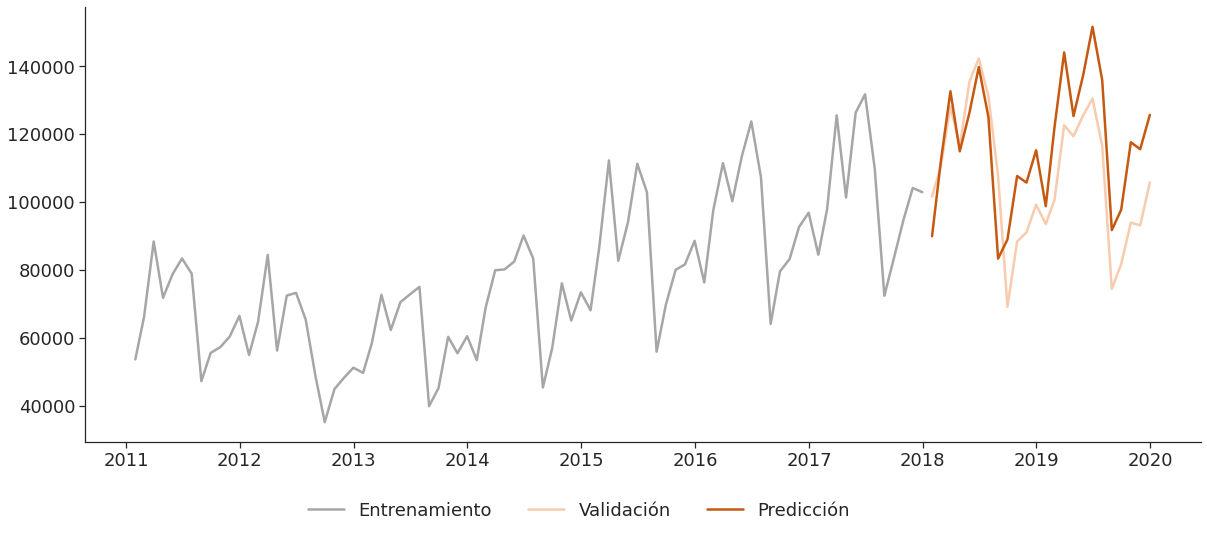

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=2.5)
plt.plot(tbats_forecast_month_2, label="Predicción", color="#C65911", linewidth=2.5)

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_tbats_month_2_LT = sqrt(mean_squared_error(validacion,tbats_forecast_month_2))
print(rms_tbats_month_2_LT)

# RMSE - 3 meses
rms_tbats_month_2_MT = sqrt(mean_squared_error(validacion[:3],tbats_forecast_month_2[:3]))
print(rms_tbats_month_2_MT)

# RMSE - 1 mes
rms_tbats_month_2_ST = sqrt(mean_squared_error(validacion[:1],tbats_forecast_month_2[:1]))
print(rms_tbats_month_2_ST)

15922.055359805052
7284.143919650503
11694.557926073569


###**<font color=21A5FF>PROPHET</font>**

#####**Dato diario**

Para aplicar este algoritmo, los datos deben tener una estructura en concreto.

La columna de fecha debe llamarse `ds` y la que contiene los datos `y`.

In [ ]:
day_ts = data.reset_index()[['date_matric', 'total']]
day_ts['ds'] = day_ts['date_matric']
day_ts['y'] = day_ts['total']
day_ts.set_index('date_matric');

In [ ]:
# Dividir entrenamiento y test
entrenamiento = day_ts[day_ts['date_matric']<='2017-12-31']
validacion = day_ts[day_ts['date_matric']>'2017-12-31']

In [ ]:
# Aplicar transformación Box-Cox 
entrenamiento['y'], lam = boxcox(entrenamiento['total']) 
entrenamiento.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date_matric,total,ds,y
0,2011-01-03,3695.0,2011-01-03,7.073063
1,2011-01-04,3693.0,2011-01-04,7.072665
2,2011-01-05,2424.0,2011-01-05,6.760524
3,2011-01-07,1394.0,2011-01-07,6.342813
4,2011-01-10,1373.0,2011-01-10,6.331230


Generar dataset al que poder añadir aquellos festivos que queramos definir.

In [ ]:
festivos = pd.DataFrame({
  'holiday': 'dia_festivo',
  'ds': pd.to_datetime([]),
  'lower_window': 0,
  'upper_window': 0,
})

In [ ]:
m = Prophet(seasonality_mode = 'additive', 
            yearly_seasonality=True,
            weekly_seasonality=True,
            holidays = festivos
            )

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.add_country_holidays(country_name='ES') # Añadir los festivos nacionales que hay en España

entrenamiento = entrenamiento[entrenamiento['ds'].dt.dayofweek < 5] # Eliminar los fines de semana

In [ ]:
# Entrenar el modelo
%time m.fit(entrenamiento)
m.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 987 ms, sys: 23.8 ms, total: 1.01 s
Wall time: 1 s


0                                        Año nuevo
1                               Epifanía del Señor
2                  Día del Trabajador (Trasladado)
3                            Asunción de la Virgen
4                             Día de la Hispanidad
5                                 Todos los Santos
6                  Día de la Constitución Española
7                         La Inmaculada Concepción
8                             Navidad (Trasladado)
9                           Año nuevo (Trasladado)
10                              Día del Trabajador
11                                         Navidad
12                 Epifanía del Señor (Trasladado)
13           La Inmaculada Concepción (Trasladado)
14               Día de la Hispanidad (Trasladado)
15                   Todos los Santos (Trasladado)
16    Día de la Constitución Española (Trasladado)
dtype: object

In [ ]:
# Definir el periodo a predecir
rango = pd.DataFrame(pd.date_range(start=entrenamiento['date_matric'].max(),
                                   end=validacion['date_matric'].max(),
                                   freq='D'))

future = m.make_future_dataframe(periods=len(rango))
future = future[future['ds'].dt.dayofweek < 5] # Eliminar los fines de semana en los valores a predecir
future = future[future['ds'].isin(day_ts['date_matric'])] # Eliminar los días en los que no hubo matriculación en la validación o el entrenamiento

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2261,2019-12-20,7.509991,7.184721,7.834752
2262,2019-12-23,7.313751,6.988568,7.635678
2263,2019-12-26,7.623114,7.292796,7.955315
2264,2019-12-27,7.661845,7.344352,7.987757
2265,2019-12-30,7.539748,7.204951,7.891499


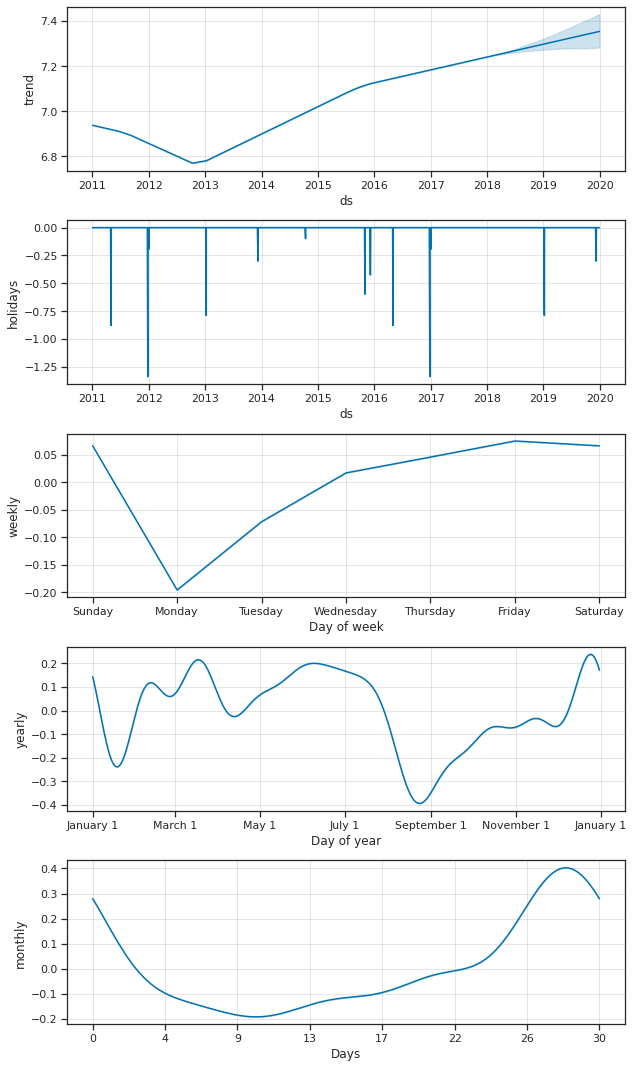

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# Invertir transformación Box-Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [ ]:
prediccion = forecast[forecast['ds']>=min(validacion['ds'])] # eliminar el entrenamiento de la predicción

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
prediccion = prediccion.set_index('ds')

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-30 00:00:00


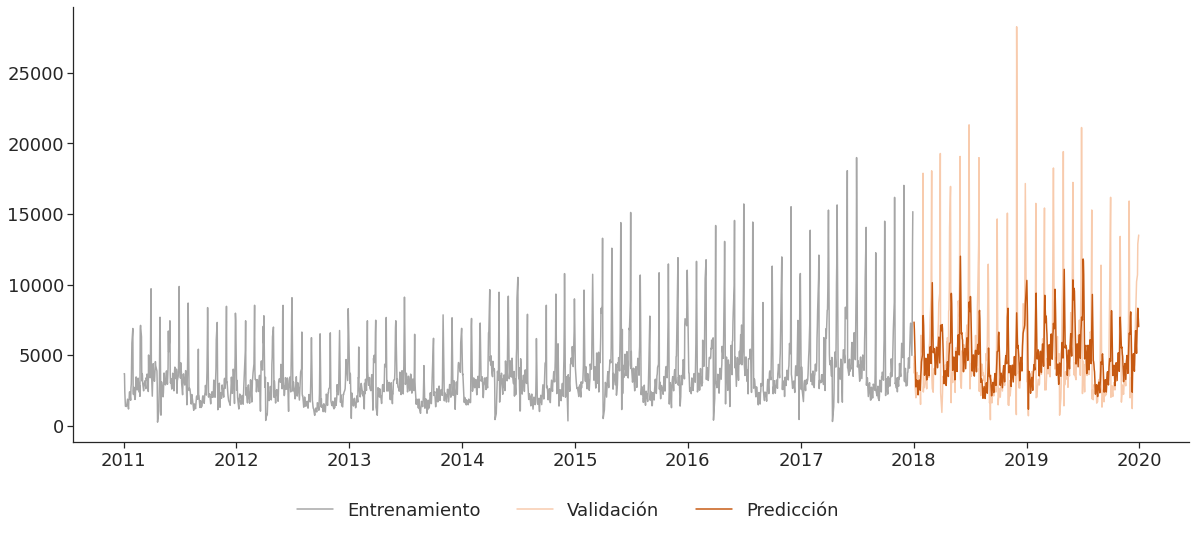

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(prediccion['yhat'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_prophet_day_LT = sqrt(mean_squared_error(validacion['total'],prediccion['yhat']))
print(rms_prophet_day_LT)

# RMSE - 3 meses
rms_prophet_day_MT = sqrt(mean_squared_error(validacion['total'][:66],prediccion['yhat'][:66]))
print(rms_prophet_day_MT)

# RMSE - 1 mes
rms_prophet_day_ST = sqrt(mean_squared_error(validacion['total'][:22],prediccion['yhat'][:22]))
print(rms_prophet_day_ST)

3523.576973392514
3759.055126473392
2695.2694751531967


#####**Mensualizar**

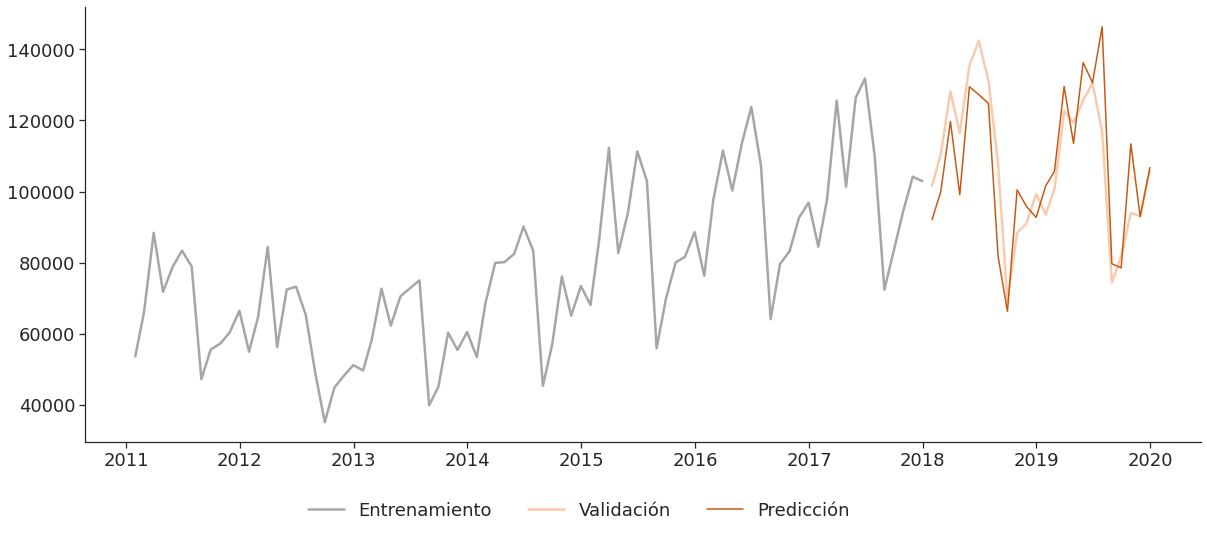

In [ ]:
month_forecast = prediccion.resample('M').apply(sum)
month_ts = day_ts.resample('M', on='ds').apply(sum)
entrenamiento_month = month_ts[:int(len(month_ts)-24)]
validacion_month = month_ts[int(len(month_ts)-24):]

rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_month['total'], label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion_month['total'], label="Validación", color="#F8CBAD", linewidth=2.5)
plt.plot(month_forecast['yhat'], label="Predicción", color="#C65911", linewidth=1.5)

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_prophet_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum).total,month_forecast['yhat']))
print(rms_prophet_month_LT)

# RMSE - 3 meses
rms_prophet_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum).total[:3],month_forecast['yhat'][:3]))
print(rms_prophet_month_MT)

# RMSE - 1 mes
rms_prophet_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum).total[:1],month_forecast['yhat'][:1]))
print(rms_prophet_month_ST)

11824.154441232458
9545.675625655445
9566.62942615118


#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
month_ts = month_ts.reset_index()[['date_matric', 'total']]
month_ts['ds'] = month_ts['date_matric']
month_ts['y'] = month_ts['total']
month_ts.set_index('date_matric');

In [ ]:
# Dividir entrenamiento y test
entrenamiento = month_ts[:int(len(month_ts)-24)]
validacion = month_ts[int(len(month_ts)-24):]

In [ ]:
validacion.count()

date_matric    24
total          24
ds             24
y              24
dtype: int64

In [ ]:
# Aplicar transformación Box-Cox 
entrenamiento['y'], lam = boxcox(entrenamiento['total']) 
entrenamiento.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date_matric,total,ds,y
0,2011-01-31,53633.0,2011-01-31,73.414031
1,2011-02-28,66116.0,2011-02-28,78.105990
2,2011-03-31,88394.0,2011-03-31,85.095250
3,2011-04-30,71803.0,2011-04-30,80.033956
4,2011-05-31,78855.0,2011-05-31,82.278132


In [ ]:
m = Prophet(seasonality_mode = 'additive')

In [ ]:
# Entrenar el modelo
%time m.fit(entrenamiento)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 1.67 s, sys: 29.6 ms, total: 1.7 s
Wall time: 1.69 s


In [ ]:
# Definir el periodo a predecir
future = m.make_future_dataframe(periods=24, freq = 'M')

In [ ]:
forecast = m.predict(future)
forecast = forecast[int(len(forecast)-24):]

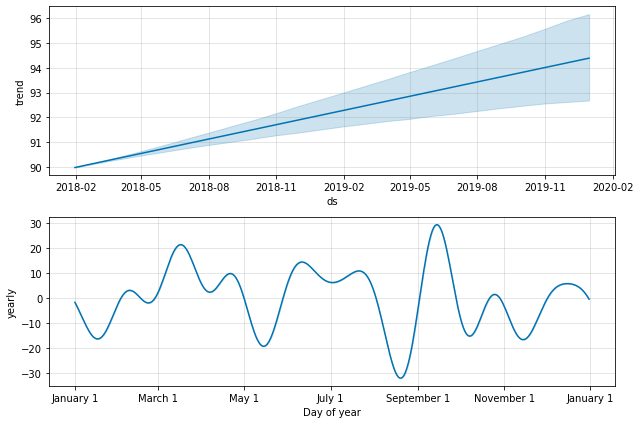

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# Invertir transformación Box-Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
forecast = forecast.set_index('ds');

Entrenamiento: 2011-01-31 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-31 00:00:00  -  2019-12-31 00:00:00


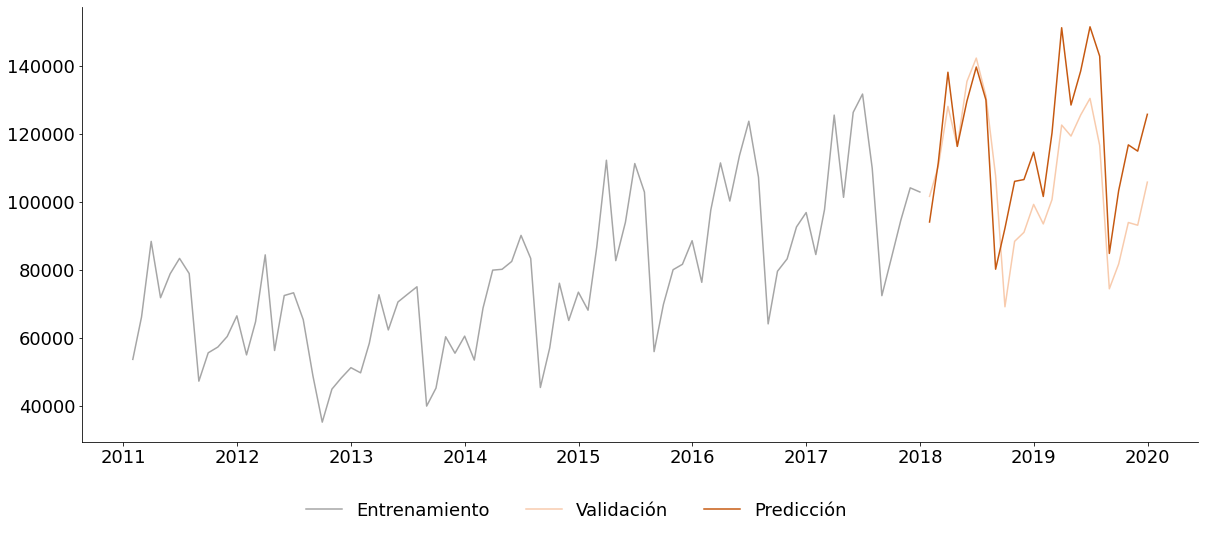

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast['yhat'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_prophet_month_2_LT = sqrt(mean_squared_error(validacion['total'],forecast['yhat']))
print(rms_prophet_month_2_LT)

# RMSE - 3 meses
rms_prophet_month_2_MT = sqrt(mean_squared_error(validacion['total'][:3],forecast['yhat'][:3]))
print(rms_prophet_month_2_MT)

# RMSE - 1 mes
rms_prophet_month_2_ST = sqrt(mean_squared_error(validacion['total'][:1],forecast['yhat'][:1]))
print(rms_prophet_month_2_ST)

16975.319455665627
7288.73985671497
7555.4616922875575


###**<font color=21A5FF>XGBoost</font>**


##### **Datos diarios**

In [ ]:
day_ts = data['total']

In [ ]:
date_cut = '2017-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
entrenamiento = pd.DataFrame({'date_matric': entrenamiento.index, 'total': entrenamiento.values}) 
validacion = pd.DataFrame({'date_matric': validacion.index, 'total': validacion.values}) 
entrenamiento['date_matric'] = pd.to_datetime(entrenamiento['date_matric'], format='%Y-%m-%d')
validacion['date_matric'] = pd.to_datetime(validacion['date_matric'], format='%Y-%m-%d')

In [ ]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_matric  1763 non-null   datetime64[ns]
 1   total        1763 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.7 KB


In [ ]:
def create_features(df, label=None):
    """
    Crear atributos de la serie temporal en base al índice
    """
    df['date_matric'] = pd.to_datetime(df['date_matric'], format='%Y-%m-%d')
    df['dayofweek'] = df['date_matric'].dt.dayofweek
    df['quarter'] = df['date_matric'].dt.quarter
    df['month'] = df['date_matric'].dt.month
    df['year'] = df['date_matric'].dt.year
    df['dayofyear'] = df['date_matric'].dt.dayofyear
    df['dayofmonth'] = df['date_matric'].dt.day
    df['weekofyear'] = df['date_matric'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(entrenamiento, label='total')
X_test, y_test = create_features(validacion, label='total')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [ ]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')

In [ ]:
# Create XGBoost Model
%time model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

CPU times: user 856 ms, sys: 28.7 ms, total: 884 ms
Wall time: 976 ms


XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=7)

El algoritmo XGBoost permite conocer la importancia de los atributos utilizados de cara a hacer la predicción. Es decir, permite cuantificar qué variables son más usadas a la hora de realizar las separaciones (splits) en el árbol de decisión. El trimestre tiene baja importancia dado que puede ser creado con diferentes cortes de otros atributos.


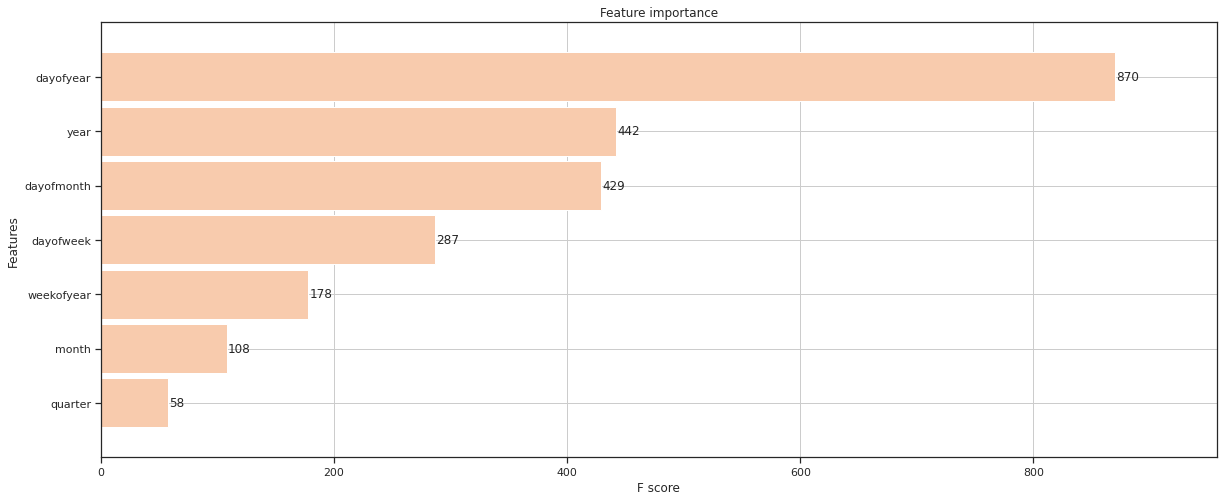

In [ ]:
plot_importance(model, height=0.9, color="#F8CBAD")

In [ ]:
forecast_XGB = model.predict(X_test)
forecast_XGB = pd.DataFrame({'date_matric': validacion['date_matric'], 'prediccion': forecast_XGB}) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
forecast_XGB = forecast_XGB.set_index('date_matric')

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


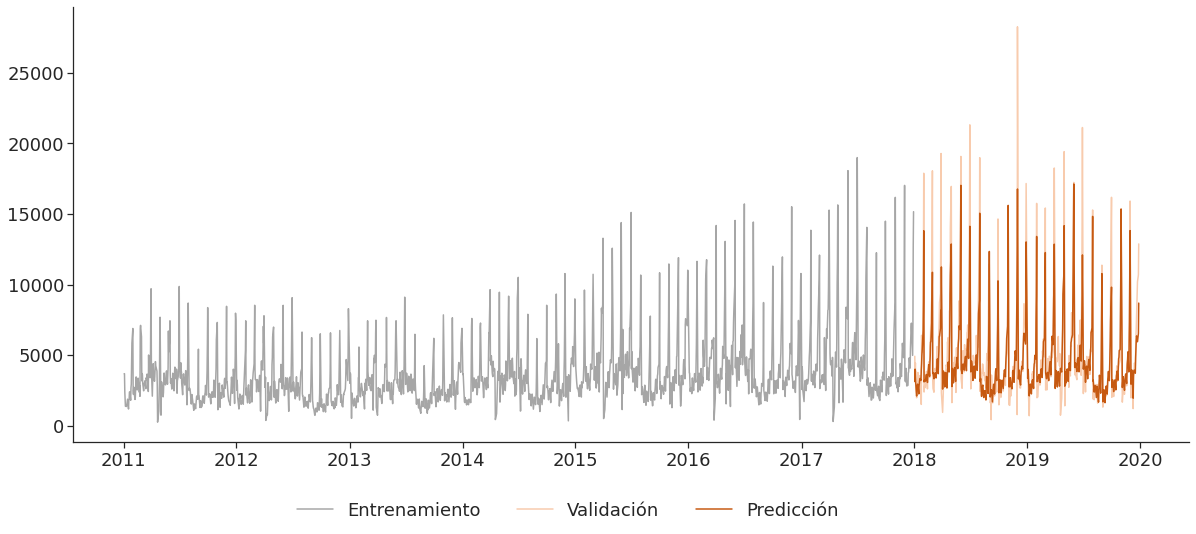

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_XGB_day_LT = sqrt(mean_squared_error(validacion['total'],forecast_XGB['prediccion']))
print(rms_XGB_day_LT)

# RMSE - 3 meses
rms_XGB_day_MT = sqrt(mean_squared_error(validacion['total'][:66],forecast_XGB['prediccion'][:66]))
print(rms_XGB_day_MT)

# RMSE - 1 mes
rms_XGB_day_ST = sqrt(mean_squared_error(validacion['total'][:22],forecast_XGB['prediccion'][:22]))
print(rms_XGB_day_ST)

1777.0019907196381
2485.595207874139
1349.976277483264


#####**Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


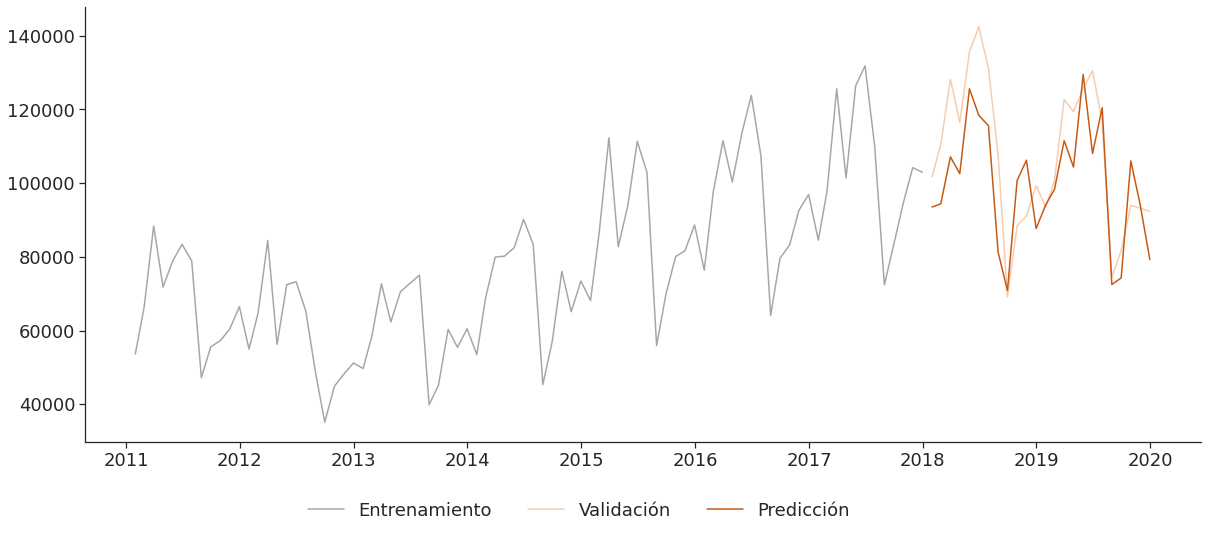

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'].resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'].resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB['prediccion'].resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_XGB_month_LT = sqrt(mean_squared_error(validacion['total'].resample('M').apply(sum),forecast_XGB['prediccion'].resample('M').apply(sum)))
print(rms_XGB_month_LT)

# RMSE - 3 meses
rms_XGB_month_MT = sqrt(mean_squared_error(validacion['total'].resample('M').apply(sum)[:3],forecast_XGB['prediccion'].resample('M').apply(sum)[:3]))
print(rms_XGB_month_MT)

# RMSE - 1 mes
rms_XGB_month_ST = sqrt(mean_squared_error(validacion['total'].resample('M').apply(sum)[:1],forecast_XGB['prediccion'].resample('M').apply(sum)[:1]))
print(rms_XGB_month_ST)

13489.511485013518
16011.366745177116
8159.8046875


#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-24)]
validacion = month_ts[int(len(month_ts)-24):]

In [ ]:
entrenamiento = pd.DataFrame({'date_matric': entrenamiento.index, 'total': entrenamiento.values}) 
validacion = pd.DataFrame({'date_matric': validacion.index, 'total': validacion.values}) 
entrenamiento['date_matric'] = pd.to_datetime(entrenamiento['date_matric'], format='%Y-%m-%d')
validacion['date_matric'] = pd.to_datetime(validacion['date_matric'], format='%Y-%m-%d')

In [ ]:
def create_features(df, label=None):
    """
    Crear atributos de la serie temporal en base al índice
    """
    df['date_matric'] = pd.to_datetime(df['date_matric'], format='%Y-%m-%d')
    df['quarter'] = df['date_matric'].dt.quarter
    df['month'] = df['date_matric'].dt.month
    df['year'] = df['date_matric'].dt.year
    
    X = df[['quarter','month','year']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(entrenamiento, label='total')
X_test, y_test = create_features(validacion, label='total')

In [ ]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')

In [ ]:
# Create XGBoost Model
%time model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

CPU times: user 211 ms, sys: 4.96 ms, total: 216 ms
Wall time: 217 ms


XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=7)

El algoritmo XGBoost permite conocer la importancia de los atributos utilizados de cara a hacer la predicción. Es decir, permite cuantificar qué variables son más usadas a la hora de realizar las separaciones (splits) en el árbol de decisión. El trimestre tiene baja importancia dado que puede ser creado con diferentes cortes de otros atributos.


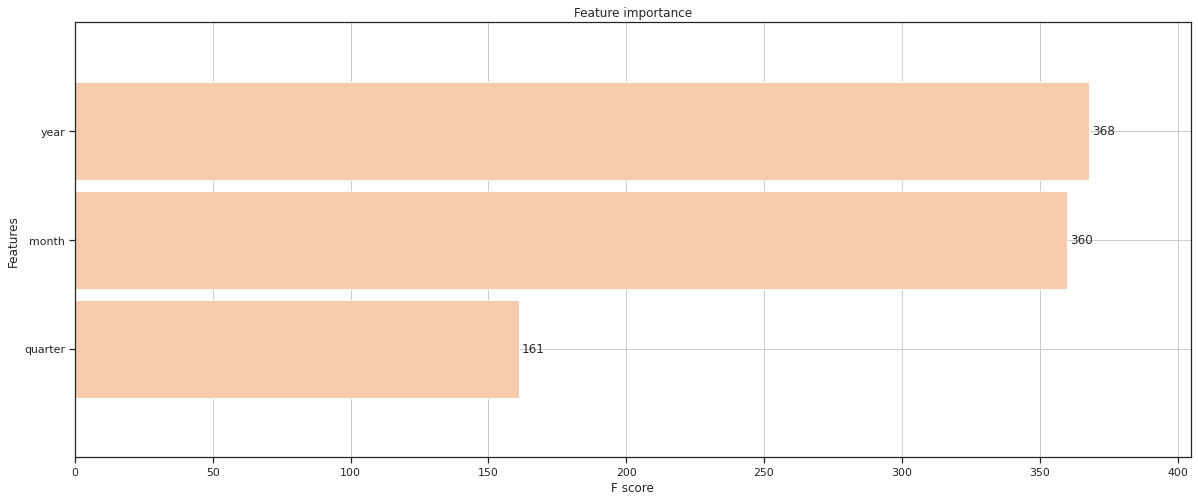

In [ ]:
plot_importance(model, height=0.9, color="#F8CBAD")

In [ ]:
forecast_XGB = model.predict(X_test)
forecast_XGB = pd.DataFrame({'date_matric': validacion['date_matric'], 'prediccion': forecast_XGB}) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
forecast_XGB = forecast_XGB.set_index('date_matric')

Entrenamiento: 2011-01-31 00:00:00  -  2017-12-31 00:00:00
Validación:  2018-01-31 00:00:00  -  2019-12-31 00:00:00


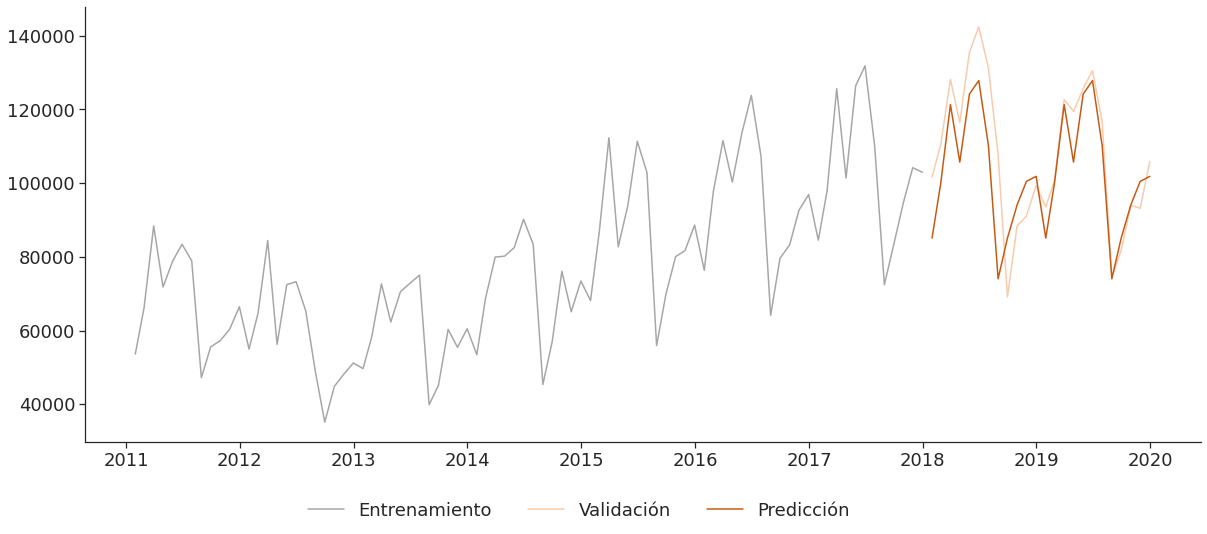

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_XGB_month_2_LT = sqrt(mean_squared_error(validacion['total'],forecast_XGB['prediccion']))
print(rms_XGB_month_2_LT)

# RMSE - 3 meses
rms_XGB_month_2_MT = sqrt(mean_squared_error(validacion['total'][:3],forecast_XGB['prediccion'][:3]))
print(rms_XGB_month_2_MT)

# RMSE - 1 mes
rms_XGB_month_2_ST = sqrt(mean_squared_error(validacion['total'][:1],forecast_XGB['prediccion'][:1]))
print(rms_XGB_month_2_ST)

11621.104469500482
11995.29649350197
16589.5703125


###**<font color=21A5FF>Red Neuronal Recurrente (RNR)</font>**

##### **Para replicar los resultados**

In [ ]:
#Para replicar resultados
# Set a seed value
seed_value= 7 

# Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

##### **Long Short-Term Memory (LSTM)**

###### **Datos diarios**

In [ ]:
day_ts = data['total']

In [ ]:
date_cut = '2017-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Ajustar el scaler sobre el conjunto de entrenamiento
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler_fit = min_max_scaler.fit(entrenamiento.values.reshape(-1, 1))

# Aplicar el scaler a los conjuntos de entrenamiento y validación
entrenamiento = min_max_scaler.transform(entrenamiento.values.reshape(-1, 1))
#validacion = min_max_scaler.transform(validacion.values.reshape(-1, 1))

In [ ]:
X_train = []
y_train = []
for i in range(60,len(entrenamiento)):
    X_train.append(entrenamiento[i-60:i,0])
    y_train.append(entrenamiento[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

En Python la red LSTM espera recibir los datos de una forma específica:

`[samples, time steps, features]`

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Crear LSTM
model = Sequential()

# Primer capa con proceso de regularización de abandono
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2, seed=7))
# Segunda capa con proceso de regularización de abandono
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2, seed=7))
# Tercera capa con proceso de regularización de abandono
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2, seed=7))
# Cuarta capa con proceso de regularización de abandono
model.add(LSTM(units=20))
model.add(Dropout(0.2, seed=7))
# Capa de salida
model.add(Dense(units=1))

# Compiling the RNN
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting to the training set
%time model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1703/1703 - 98s - loss: 0.0147 - 98s/epoch - 58ms/step
Epoch 2/20
1703/1703 - 90s - loss: 0.0129 - 90s/epoch - 53ms/step
Epoch 3/20
1703/1703 - 90s - loss: 0.0119 - 90s/epoch - 53ms/step
Epoch 4/20
1703/1703 - 89s - loss: 0.0112 - 89s/epoch - 52ms/step
Epoch 5/20
1703/1703 - 90s - loss: 0.0108 - 90s/epoch - 53ms/step
Epoch 6/20
1703/1703 - 90s - loss: 0.0106 - 90s/epoch - 53ms/step
Epoch 7/20
1703/1703 - 90s - loss: 0.0102 - 90s/epoch - 53ms/step
Epoch 8/20
1703/1703 - 88s - loss: 0.0100 - 88s/epoch - 52ms/step
Epoch 9/20
1703/1703 - 91s - loss: 0.0098 - 91s/epoch - 54ms/step
Epoch 10/20
1703/1703 - 90s - loss: 0.0096 - 90s/epoch - 53ms/step
Epoch 11/20
1703/1703 - 92s - loss: 0.0097 - 92s/epoch - 54ms/step
Epoch 12/20
1703/1703 - 90s - loss: 0.0096 - 90s/epoch - 53ms/step
Epoch 13/20
1703/1703 - 91s - loss: 0.0091 - 91s/epoch - 54ms/step
Epoch 14/20
1703/1703 - 91s - loss: 0.0091 - 91s/epoch - 53ms/step
Epoch 15/20
1703/1703 - 90s - loss: 0.0088 - 90s/epoch - 53ms/step
Epoc

In [ ]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            1760      
                                                                 
 dropout (Dropout)           (None, 60, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 20)            3280      
                                                                 
 dropout_1 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 20)            3280      
                                                                 
 dropout_2 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                3

In [ ]:
inputs = day_ts[len(day_ts)-len(validacion) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = min_max_scaler.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_LSTM_forecast = model.predict(X_test)
y_LSTM_forecast = min_max_scaler.inverse_transform(y_LSTM_forecast)

In [ ]:
LSTM_forecast = pd.DataFrame(y_LSTM_forecast, index = validacion.index) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = day_ts.iloc[start_en:end_en]

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


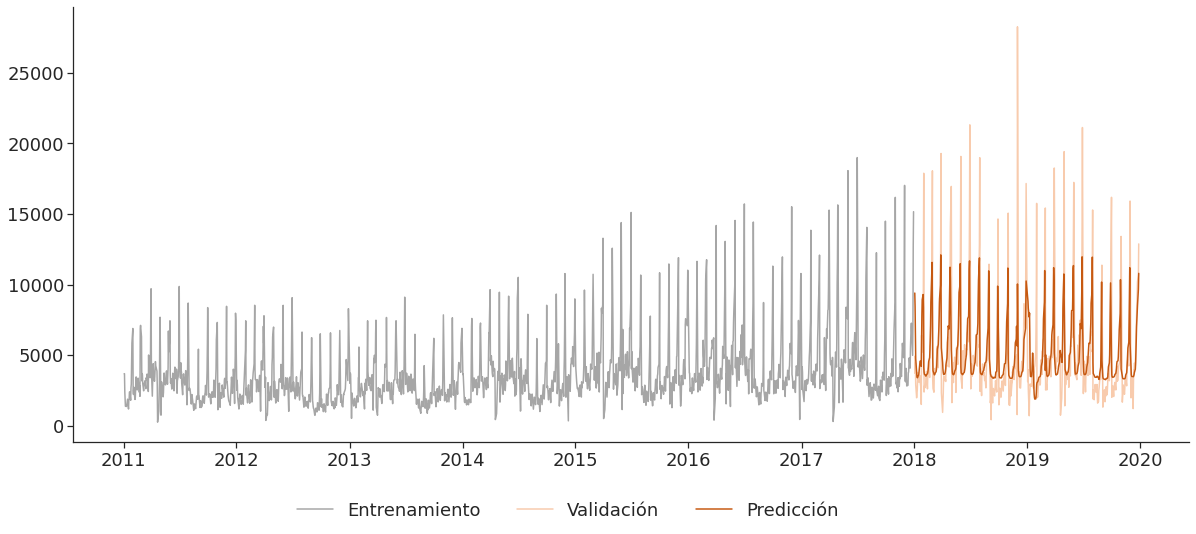

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(LSTM_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
LSTM_day_LT = sqrt(mean_squared_error(validacion,LSTM_forecast))
print(LSTM_day_LT)

# RMSE - 3 meses
LSTM_day_MT = sqrt(mean_squared_error(validacion[:66],LSTM_forecast[:66]))
print(LSTM_day_MT)

# RMSE - 1 mes
LSTM_day_ST = sqrt(mean_squared_error(validacion[:22],LSTM_forecast[:22]))
print(LSTM_day_ST)

2911.445909531546
3032.7440385522045
3694.18797555251


###### **Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


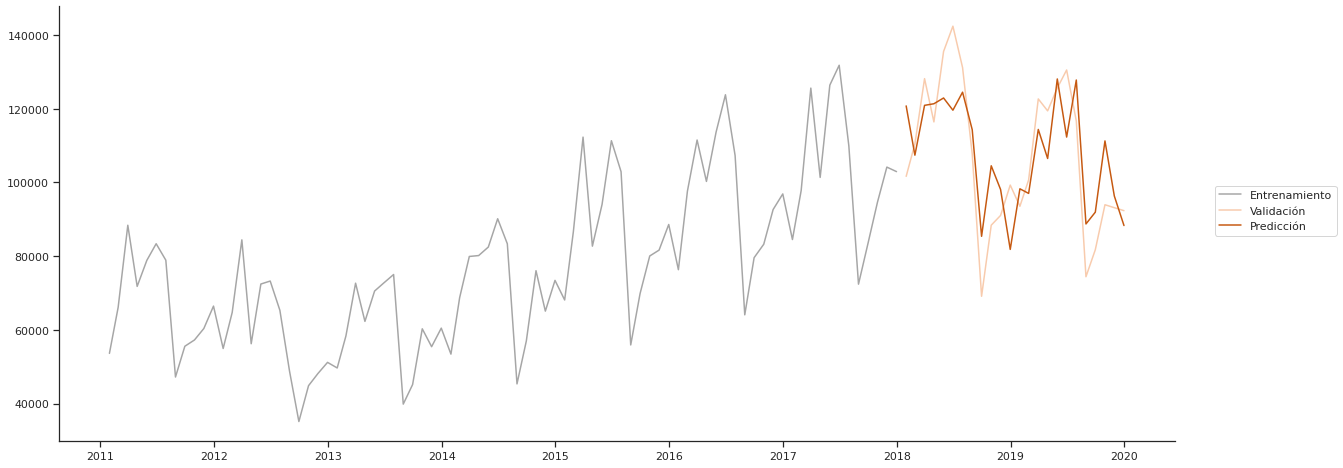

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(LSTM_forecast.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(1.15, 0.6))

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
LSTM_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum),LSTM_forecast.resample('M').apply(sum)))
print(LSTM_month_LT)

# RMSE - 3 meses
LSTM_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:3],LSTM_forecast.resample('M').apply(sum)[:3]))
print(LSTM_month_MT)

# RMSE - 1 mes
LSTM_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:1],LSTM_forecast.resample('M').apply(sum)[:1]))
print(LSTM_month_ST)

12012.203671241721
11929.646797620751
19107.140625


##### **Gated Recurrent Units (GRU)**

###### **Datos diarios**

In [ ]:
day_ts = data['total']

In [ ]:
date_cut = '2017-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Ajustar el scaler sobre el conjunto de entrenamiento
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler_fit = min_max_scaler.fit(entrenamiento.values.reshape(-1, 1))

# Aplicar el scaler a los conjuntos de entrenamiento y validación
entrenamiento = min_max_scaler.transform(entrenamiento.values.reshape(-1, 1))
#validacion = min_max_scaler.transform(validacion.values.reshape(-1, 1))

In [ ]:
X_train = []
y_train = []
for i in range(60,len(entrenamiento)):
    X_train.append(entrenamiento[i-60:i,0])
    y_train.append(entrenamiento[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

En Python la red LSTM espera recibir los datos de una forma específica:

`[samples, time steps, features]`

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Crear GRU
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=20, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# Second GRU layer
model.add(GRU(units=20, return_sequences=True))
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=20, return_sequences=True))
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=20))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting to the training set
%time model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1703/1703 - 106s - loss: 0.0146 - 106s/epoch - 62ms/step
Epoch 2/20
1703/1703 - 84s - loss: 0.0123 - 84s/epoch - 49ms/step
Epoch 3/20
1703/1703 - 85s - loss: 0.0116 - 85s/epoch - 50ms/step
Epoch 4/20
1703/1703 - 84s - loss: 0.0110 - 84s/epoch - 50ms/step
Epoch 5/20
1703/1703 - 82s - loss: 0.0104 - 82s/epoch - 48ms/step
Epoch 6/20
1703/1703 - 83s - loss: 0.0102 - 83s/epoch - 49ms/step
Epoch 7/20
1703/1703 - 82s - loss: 0.0101 - 82s/epoch - 48ms/step
Epoch 8/20
1703/1703 - 83s - loss: 0.0100 - 83s/epoch - 49ms/step
Epoch 9/20
1703/1703 - 87s - loss: 0.0098 - 87s/epoch - 51ms/step
Epoch 10/20
1703/1703 - 82s - loss: 0.0093 - 82s/epoch - 48ms/step
Epoch 11/20
1703/1703 - 88s - loss: 0.0095 - 88s/epoch - 51ms/step
Epoch 12/20
1703/1703 - 107s - loss: 0.0092 - 107s/epoch - 63ms/step
Epoch 13/20
1703/1703 - 85s - loss: 0.0090 - 85s/epoch - 50ms/step
Epoch 14/20
1703/1703 - 101s - loss: 0.0085 - 101s/epoch - 59ms/step
Epoch 15/20
1703/1703 - 82s - loss: 0.0082 - 82s/epoch - 48ms/ste

In [ ]:
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 20)            1380      
                                                                 
 dropout_8 (Dropout)         (None, 60, 20)            0         
                                                                 
 gru_5 (GRU)                 (None, 60, 20)            2520      
                                                                 
 dropout_9 (Dropout)         (None, 60, 20)            0         
                                                                 
 gru_6 (GRU)                 (None, 60, 20)            2520      
                                                                 
 dropout_10 (Dropout)        (None, 60, 20)            0         
                                                                 
 gru_7 (GRU)                 (None, 20)               

In [ ]:
inputs = day_ts[len(day_ts)-len(validacion) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = min_max_scaler.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_GRU_forecast = model.predict(X_test)
y_GRU_forecast = min_max_scaler.inverse_transform(y_GRU_forecast)

In [ ]:
GRU_forecast = pd.DataFrame(y_GRU_forecast, index = validacion.index) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = day_ts.iloc[start_en:end_en]

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


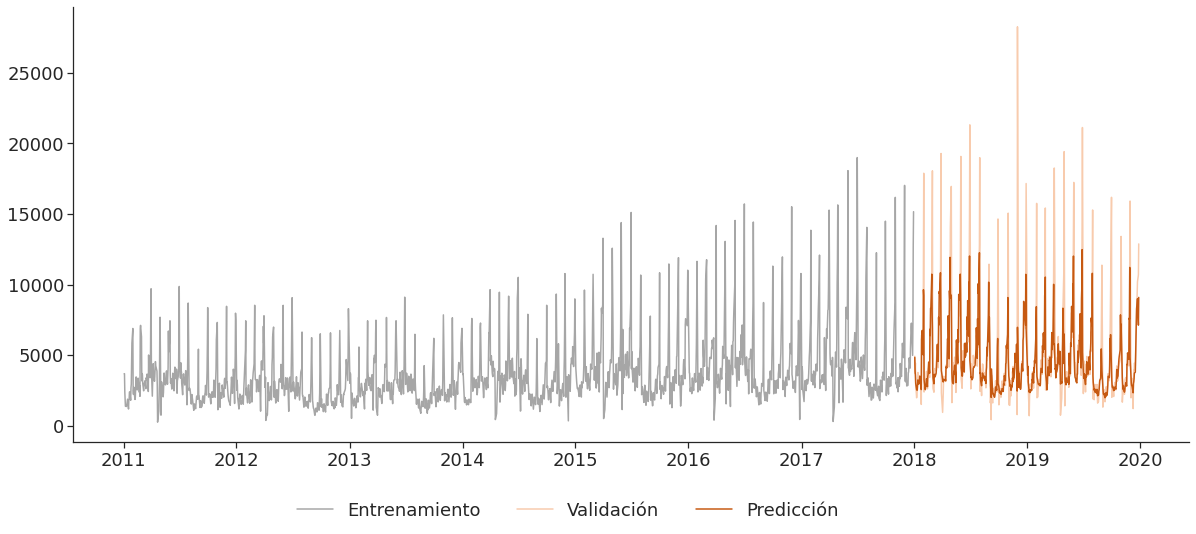

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(GRU_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
GRU_day_LT = sqrt(mean_squared_error(validacion,GRU_forecast))
print(GRU_day_LT)

# RMSE - 3 meses
GRU_day_MT = sqrt(mean_squared_error(validacion[:66],GRU_forecast[:66]))
print(GRU_day_MT)

# RMSE - 1 mes
GRU_day_ST = sqrt(mean_squared_error(validacion[:22],GRU_forecast[:22]))
print(GRU_day_ST)

2739.1774878910524
2740.5267308974035
1934.7410567894954


###### **Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


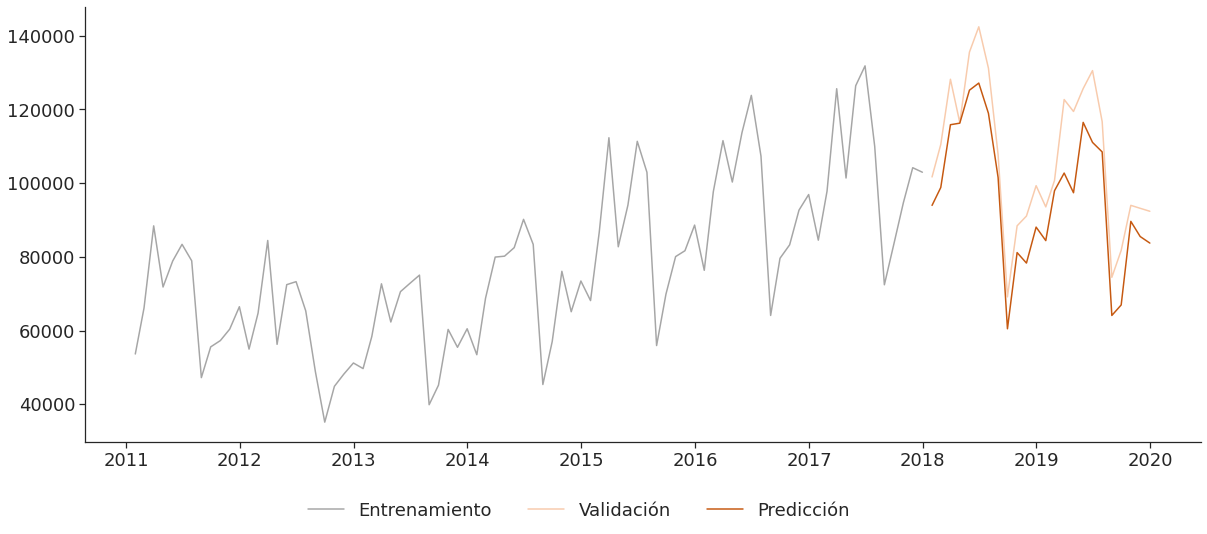

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(GRU_forecast.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
GRU_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum),GRU_forecast.resample('M').apply(sum)))
print(GRU_month_LT)

# RMSE - 3 meses
GRU_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:3],GRU_forecast.resample('M').apply(sum)[:3]))
print(GRU_month_MT)

# RMSE - 1 mes
GRU_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:1],GRU_forecast.resample('M').apply(sum)[:1]))
print(GRU_month_ST)

11685.385246179352
10767.777373950075
7713.359375


##**<font color=FF6633>Extra: por canales**</font>

###**<font color=21A5FF>XGBoost</font>**


##### **Datos diarios**

In [ ]:
day_ts = data['total']

day_ts_alquilador = data['ALQUILADOR']
day_ts_empresa = data['EMPRESA']
day_ts_particular = data['PARTICULAR']

In [ ]:
date_cut = '2017-12-31'

start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))

entrenamiento = day_ts.iloc[start_en:end_en]
entrenamiento_alquilador = day_ts_alquilador.iloc[start_en:end_en]
entrenamiento_empresa = day_ts_empresa.iloc[start_en:end_en]
entrenamiento_particular = day_ts_particular.iloc[start_en:end_en]


start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))

validacion = day_ts.iloc[start_va:end_va]
validacion_alquilador = day_ts_alquilador.iloc[start_va:end_va]
validacion_empresa = day_ts_empresa.iloc[start_va:end_va]
validacion_particular = day_ts_particular.iloc[start_va:end_va]

In [ ]:
entrenamiento = pd.DataFrame({'date_matric': entrenamiento.index, 'total': entrenamiento.values}) 
validacion = pd.DataFrame({'date_matric': validacion.index, 'total': validacion.values}) 
entrenamiento['date_matric'] = pd.to_datetime(entrenamiento['date_matric'], format='%Y-%m-%d')
validacion['date_matric'] = pd.to_datetime(validacion['date_matric'], format='%Y-%m-%d')

entrenamiento_alquilador = pd.DataFrame({'date_matric': entrenamiento_alquilador.index, 'total': entrenamiento_alquilador.values}) 
validacion_alquilador = pd.DataFrame({'date_matric': validacion_alquilador.index, 'total': validacion_alquilador.values}) 
entrenamiento_alquilador['date_matric'] = pd.to_datetime(entrenamiento_alquilador['date_matric'], format='%Y-%m-%d')
validacion_alquilador['date_matric'] = pd.to_datetime(validacion_alquilador['date_matric'], format='%Y-%m-%d')

entrenamiento_empresa = pd.DataFrame({'date_matric': entrenamiento_empresa.index, 'total': entrenamiento_empresa.values}) 
validacion_empresa = pd.DataFrame({'date_matric': validacion_empresa.index, 'total': validacion_empresa.values}) 
entrenamiento_empresa['date_matric'] = pd.to_datetime(entrenamiento_empresa['date_matric'], format='%Y-%m-%d')
validacion_empresa['date_matric'] = pd.to_datetime(validacion_empresa['date_matric'], format='%Y-%m-%d')

entrenamiento_particular = pd.DataFrame({'date_matric': entrenamiento_particular.index, 'total': entrenamiento_particular.values}) 
validacion_particular = pd.DataFrame({'date_matric': validacion_particular.index, 'total': validacion_particular.values}) 
entrenamiento_particular['date_matric'] = pd.to_datetime(entrenamiento_particular['date_matric'], format='%Y-%m-%d')
validacion_particular['date_matric'] = pd.to_datetime(validacion_particular['date_matric'], format='%Y-%m-%d')

In [ ]:
def create_features(df, label=None):
    """
    Crear atributos de la serie temporal en base al índice
    """
    df['date_matric'] = pd.to_datetime(df['date_matric'], format='%Y-%m-%d')
    df['dayofweek'] = df['date_matric'].dt.dayofweek
    df['quarter'] = df['date_matric'].dt.quarter
    df['month'] = df['date_matric'].dt.month
    df['year'] = df['date_matric'].dt.year
    df['dayofyear'] = df['date_matric'].dt.dayofyear
    df['dayofmonth'] = df['date_matric'].dt.day
    df['weekofyear'] = df['date_matric'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train_alquilador, y_train_alquilador = create_features(entrenamiento_alquilador, label='total')
X_test_alquilador, y_test_alquilador = create_features(validacion_alquilador, label='total')

X_train_empresa, y_train_empresa = create_features(entrenamiento_empresa, label='total')
X_test_empresa, y_test_empresa = create_features(validacion_empresa, label='total')

X_train_particular, y_train_particular = create_features(entrenamiento_particular, label='total')
X_test_particular, y_test_particular = create_features(validacion_particular, label='total')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprec

In [ ]:
model_alquilador = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')
model_empresa = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')
model_particular = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')

In [ ]:
# Create XGBoost Model
%time model_alquilador.fit(X_train_alquilador, y_train_alquilador, eval_set=[(X_train_alquilador, y_train_alquilador), (X_test_alquilador, y_test_alquilador)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

%time model_empresa.fit(X_train_empresa, y_train_empresa, eval_set=[(X_train_empresa, y_train_empresa), (X_test_empresa, y_test_empresa)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

%time model_particular.fit(X_train_particular, y_train_particular, eval_set=[(X_train_particular, y_train_particular), (X_test_particular, y_test_particular)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

CPU times: user 527 ms, sys: 3.78 ms, total: 531 ms
Wall time: 528 ms
CPU times: user 1.24 s, sys: 10.4 ms, total: 1.25 s
Wall time: 1.24 s
CPU times: user 2.1 s, sys: 22.3 ms, total: 2.12 s
Wall time: 2.12 s


XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=7)

El algoritmo XGBoost permite conocer la importancia de los atributos utilizados de cara a hacer la predicción. Es decir, permite cuantificar qué variables son más usadas a la hora de realizar las separaciones (splits) en el árbol de decisión. El trimestre tiene baja importancia dado que puede ser creado con diferentes cortes de otros atributos.


In [ ]:
forecast_XGB_alquilador = model_alquilador.predict(X_test_alquilador)
forecast_XGB_alquilador = pd.DataFrame({'date_matric': validacion_alquilador['date_matric'], 'prediccion': forecast_XGB_alquilador}) # para obtener fechas de las previsiones

forecast_XGB_empresa = model_empresa.predict(X_test_empresa)
forecast_XGB_empresa = pd.DataFrame({'date_matric': validacion_empresa['date_matric'], 'prediccion': forecast_XGB_empresa}) # para obtener fechas de las previsiones

forecast_XGB_particular = model_particular.predict(X_test_particular)
forecast_XGB_particular = pd.DataFrame({'date_matric': validacion_particular['date_matric'], 'prediccion': forecast_XGB_particular}) # para obtener fechas de las previsiones

In [ ]:
entrenamiento_alquilador = entrenamiento_alquilador.set_index('date_matric')
validacion_alquilador = validacion_alquilador.set_index('date_matric')
forecast_XGB_alquilador = forecast_XGB_alquilador.set_index('date_matric')

entrenamiento_empresa = entrenamiento_empresa.set_index('date_matric')
validacion_empresa = validacion_empresa.set_index('date_matric')
forecast_XGB_empresa = forecast_XGB_empresa.set_index('date_matric')

entrenamiento_particular = entrenamiento_particular.set_index('date_matric')
validacion_particular = validacion_particular.set_index('date_matric')
forecast_XGB_particular = forecast_XGB_particular.set_index('date_matric')

entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


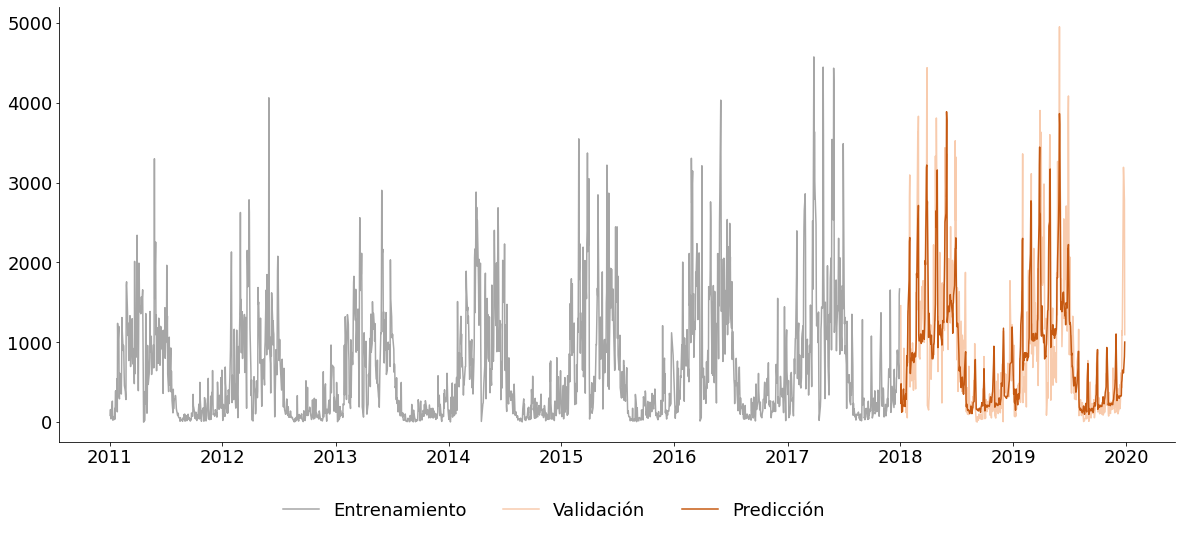

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_alquilador['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_alquilador['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_alquilador['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


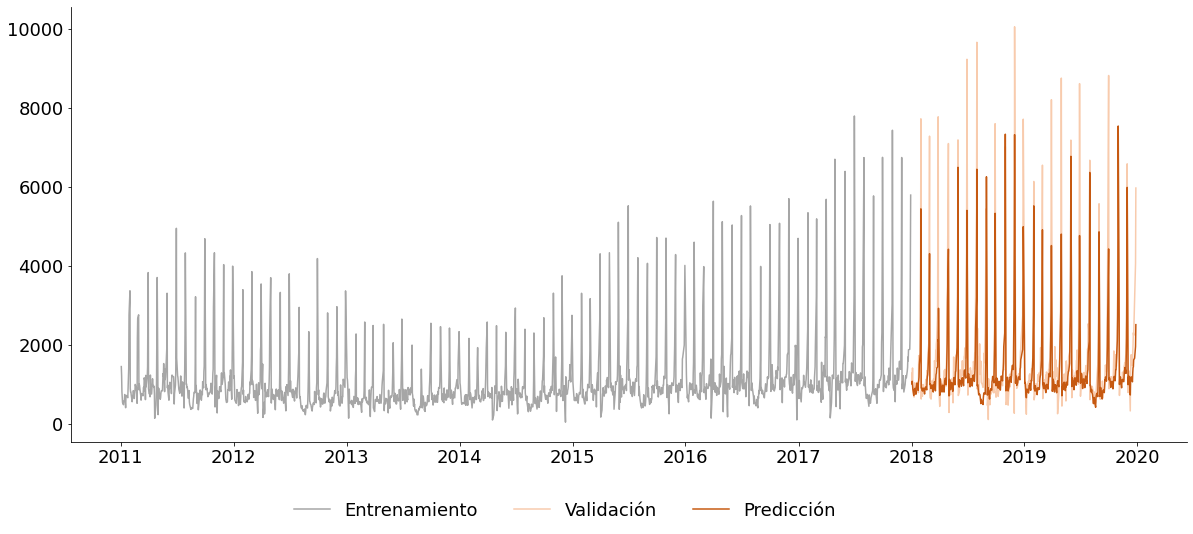

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_empresa['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_empresa['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_empresa['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


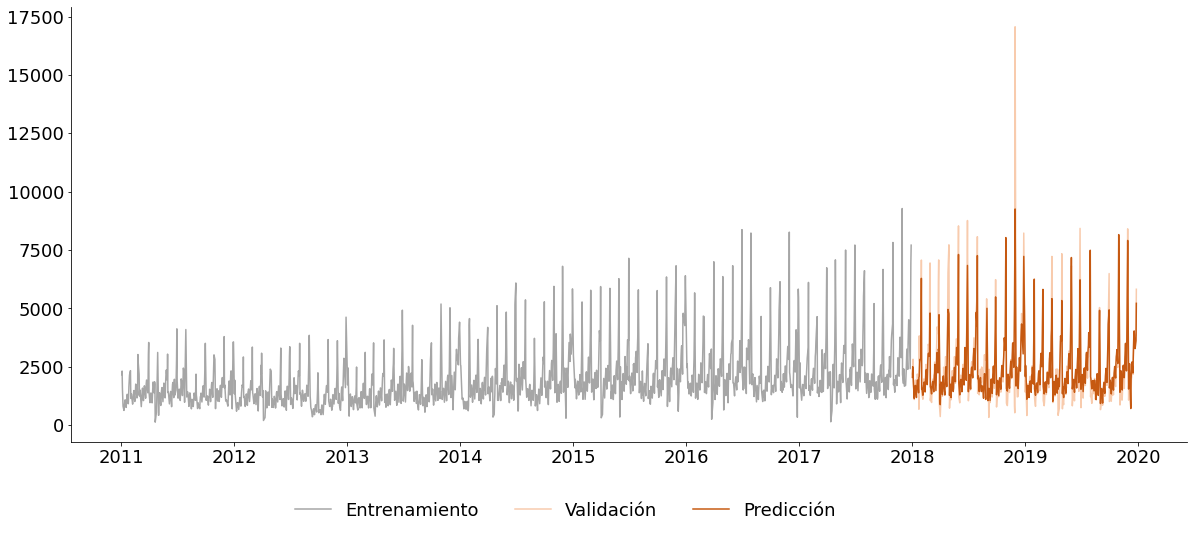

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_particular['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_particular['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_particular['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
forecast_XGB_total = forecast_XGB_alquilador.merge(forecast_XGB_empresa, how='outer', on='date_matric')
forecast_XGB_total = forecast_XGB_total.merge(forecast_XGB_particular, how='outer', on='date_matric')

In [ ]:
forecast_XGB_total['prediccion_total'] = forecast_XGB_total['prediccion_x'] + forecast_XGB_total['prediccion_y'] + forecast_XGB_total['prediccion']
forecast_XGB_total.head()

,prediccion_x,prediccion_y,prediccion,prediccion_total
date_matric,,,,
2018-01-02,237.860718,1008.893066,2045.223022,3291.976807
2018-01-03,481.378204,1075.874512,2501.432373,4058.685059
2018-01-04,330.943176,967.395142,2247.052979,3545.391357
2018-01-05,124.294167,880.921570,1883.564453,2888.780273
2018-01-08,217.001221,715.886414,1138.032104,2070.919678


Entrenamiento: 2011-01-03 00:00:00  -  2017-12-29 00:00:00
Validación:  2018-01-02 00:00:00  -  2019-12-27 00:00:00


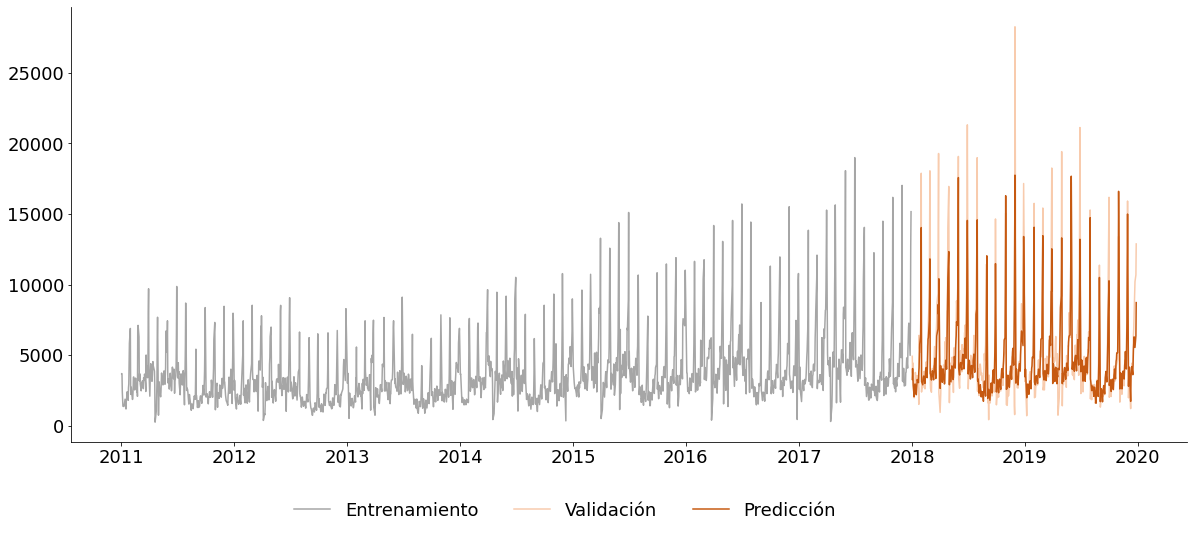

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_total['prediccion_total'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_XGB_day_LT = sqrt(mean_squared_error(validacion['total'],forecast_XGB_total['prediccion_total']))
print(rms_XGB_day_LT)

# RMSE - 3 meses
rms_XGB_day_MT = sqrt(mean_squared_error(validacion['total'][:66],forecast_XGB_total['prediccion_total'][:66]))
print(rms_XGB_day_MT)

# RMSE - 1 mes
rms_XGB_day_ST = sqrt(mean_squared_error(validacion['total'][:22],forecast_XGB_total['prediccion_total'][:22]))
print(rms_XGB_day_ST)

1746.5498697114294
2391.627511929578
1288.3739455043947
